# PHASE 1: DATA CLEANING AND PREPARATION

* Before preparing the data, we will import all the necessary packages we will be using throughout

In [326]:
# import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
from datetime import timedelta
from sklearn.model_selection import train_test_split
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer, SimpleImputer

from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# !pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
os.getcwd()
import warnings
warnings.filterwarnings('ignore')

!pip install seaborn
import seaborn as sns

In [327]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import all datasets we will be working with
* Note, that the files **charlson.csv** and **comorbidities.csv** were the outputs of the notebook ***ICD***; In this notebook, all the ICD codes of patients were cleaned, processed, and converted to a Charlson comorbidity score. Ideally, if you want to run this analysis from start to finish, then please begin with that notebook

In [328]:
# Import the labels data
labels = pd.read_csv("data/labels.csv")

# Import the vitals data
vitals = pd.read_csv("data/vitals.csv")

# Import the demographics data
demographics = pd.read_csv("data/unchanginginputs.csv")

# Import the ICU admission - this will help us label who and who did not enter the ICU
icu_admission = pd.read_csv("icuadmission.csv", parse_dates=["admit_time"], 
                            usecols=["patient_id","admit_time"])

# Charlson dataset - These files were obtained from the processing of the ICD9 and ICD10 data in the notebook "ICD"
cci = pd.read_csv('charlson.csv')

# Comorbidity dataset
cmb = pd.read_csv('comorbidities.csv')

# Import Medical History data
medhist = pd.read_csv("medhist.csv")

## Process the labels dataset 
* Here we will be restructuring the labels dataset so we can work with it. Specifically, we need to make each event type (death, sepsis) a separate column, coded as a binary indicator (0 = No Sepsis, 1 = Yes Sepsis)
* The function below assumes the data have the following columns: 
    * patient_id
    * labels_time
    * labels_value
    * type

## Work with the Vital Signs dataset
* This function will take in the vitals dataset and restructure it, so that each vital sign is a separate column, and participants have multiple rows for each time they were measured on each vital sign

In [329]:
def process_vitals_data(vitals=vitals):
    # convert the vitals_time column to a date_time

    vitals["vitals_time"] = pd.to_datetime(vitals["vitals_time"])

    # We want to convert the data to wide format - with a separate column per vital
    # The rows should be patient id, and within each patient id, the time when each vital was measured
    vitals_pivot = vitals.pivot_table(index = ["patient_id","vitals_time"], columns = "type", 
                                      values = "vitals_value", aggfunc=np.mean)
    
    # Reset the index to return the patient ID as a column, and remove the column index name
    vitals_pivot.reset_index(inplace=True)
    vitals_pivot.columns.rename("", inplace=True)

    # We will create a column called "Start" that codes people's initial measurement time
    vitals_pivot['start'] = vitals_pivot.groupby("patient_id")["vitals_time"].transform(np.min)

    # We will create a column called "end" which codes the last measurement time
    vitals_pivot['end'] = vitals_pivot.groupby("patient_id")["vitals_time"].transform(np.max)
    
    # We will calculate the end relative to start time as "end_minus_start"   
    vitals_pivot["end_minus_start"] = vitals_pivot["end"] - vitals_pivot["start"]
    
    # Create a smaller data frame that includes start, end, end-minus-start columns only
    # This will be used in the demographics dataset to code when sepsis and death occurred relative to when 
    # participants started being measured
    vitals_start_end_times = vitals_pivot.groupby("patient_id")[["start","end","end_minus_start"]].agg(np.max)
    
    # Now we will create a "time" column that codes when each vital measurement took place in relation to start time
    vitals_pivot["time"] = vitals_pivot["vitals_time"] - vitals_pivot["start"] 
    
    # Convert the "time" column into a timedelta so we can work with it (changing its units in hours)
    # Specifically, hours since the participant started being measured
    vitals_pivot["time_hrs"] = vitals_pivot["time"].apply(lambda x: x/np.timedelta64(1, 'h'))
    
    # Return the restructured vitals data and the smaller data frame with start and end times
    return vitals_pivot, vitals_start_end_times

# Apply function
vitals_pivot, vitals_start_end_times = process_vitals_data(vitals)

# Preview dataset and view its information
display(vitals_pivot.head())
display(vitals_pivot.info())

,patient_id,vitals_time,diastolic_bp,heart_rate,respiratory_rate,spo2,systolic_bp,temperature,start,end,end_minus_start,time,time_hrs
0,!!1x!aZqJeC,1893-12-20 02:52:00,58.0,118.0,20.0,NaN,97.0,NaN,1893-12-20 02:52:00,1893-12-20 06:22:00,0 days 03:30:00,00:00:00,0.000000
1,!!1x!aZqJeC,1893-12-20 03:33:00,50.0,118.0,NaN,NaN,77.0,NaN,1893-12-20 02:52:00,1893-12-20 06:22:00,0 days 03:30:00,00:41:00,0.683333
2,!!1x!aZqJeC,1893-12-20 04:00:00,NaN,NaN,NaN,NaN,NaN,32.788889,1893-12-20 02:52:00,1893-12-20 06:22:00,0 days 03:30:00,01:08:00,1.133333
3,!!1x!aZqJeC,1893-12-20 06:22:00,56.0,120.0,NaN,89.0,93.0,NaN,1893-12-20 02:52:00,1893-12-20 06:22:00,0 days 03:30:00,03:30:00,3.500000
4,!!9eBPyBLMo,2148-09-15 21:54:00,95.0,NaN,NaN,100.0,142.0,NaN,2148-09-15 21:54:00,2148-09-19 11:00:00,3 days 13:06:00,00:00:00,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6075982 entries, 0 to 6075981
Data columns (total 13 columns):
patient_id          object
vitals_time         datetime64[ns]
diastolic_bp        float64
heart_rate          float64
respiratory_rate    float64
spo2                float64
systolic_bp         float64
temperature         float64
start               datetime64[ns]
end                 datetime64[ns]
end_minus_start     timedelta64[ns]
time                timedelta64[ns]
time_hrs            float64
dtypes: datetime64[ns](3), float64(7), object(1), timedelta64[ns](2)
memory usage: 602.6+ MB


None

## Demographics, labels, icu admission data
* We will now clean the demographics dataset, combinining it with the labels and ICU admission dataset

In [330]:
# Before applying the function, I created a function to replace outliers with nans
# Th

def replace_iqr(series):
    intq = series.quantile(0.75) - series.quantile(0.25)
    upperlimit = series.quantile(0.75) + 1.5*intq
    lowerlimit = series.quantile(0.25) - 1.5*intq
    series.loc[(series < lowerlimit) | (series > upperlimit)] = np.nan
    return series

* Below is a function that takes in the above datasets, processes them, and splits them into training and test sets, and then removes outliers from each. Cox regression is highly sensitive to outliers, so this step is necessary
* The outlier function above is done separately on both the training and testing datasets
* This is because, the testing set should not be influenced by the training set - i.e., we shouldn't cut outliers in the testing set based on the interquartile range of the training set or the full dataset combined

In [333]:
def process_datasets(demographics=demographics, labels=labels, vitals=vitals_start_end_times, icu_admission=icu_admission,
                        cci = cci, cmb = cmb, medhist=medhist):
    # restructure the demographics dataset so that each measure is a column and display the result
    demographics = demographics.pivot_table(index = "patient_id", columns="type", values = "unchanginginputs_value", aggfunc=np.mean)
    demographics.columns.rename("", inplace=True)

    # Reset the index (patient_id) so it becomes a column in the data frame
    demographics.reset_index(inplace=True)
        
    ### Restructure the labels dataset to get separate columns for each event (death, sepsis3, sepsis3icd)
    labels = labels.pivot(index = "patient_id", columns = "type", values = ["labels_time", 'labels_value'])
    labels.columns = labels.columns.droplevel(level=0)
    labels.columns.rename("", inplace=True)

    collist = list(labels.columns)

    # Append the word "time" to the end of the columns
    colnames = ["{}_time".format(column_name) for column_name in list(labels.columns[0:3])]
    colnames = colnames + list(labels.columns[3:])

    # Assign this list to the column names of the labels dataset
    labels.columns = colnames

    # Reset the index
    labels = labels.reset_index()
    
    # Merge to the labels data
    demog_labels = pd.merge(left = demographics, right = labels, on = "patient_id")
    
    # Convert all the "time" columns to a datetime format
    demog_labels["death_time"] = pd.to_datetime(demog_labels["death_time"])
    demog_labels["sepsis3_time"] = pd.to_datetime(demog_labels["sepsis3_time"])
    demog_labels["sepsis3_icd_time"] = pd.to_datetime(demog_labels["sepsis3_icd_time"])
    
    # Consolidate the sepsis3 columns into a single column indicating the time when sepsis occurred
    demog_labels["sepsis_time"] = np.where(demog_labels["sepsis3_time"].isna(), 
                                                 demog_labels["sepsis3_icd_time"],
                                                 demog_labels["sepsis3_time"])
    
    # Now create a "sepsis" label column - whether you have or do not have sepsis
    # The code below will make a new binary column called "sepsis"
    # Which will be the maximum of the sepsis3 or sepsis3_icd cols (thus, will either be 0 or 1)
    demog_labels["sepsis"] = demog_labels[["sepsis3","sepsis3_icd"]].apply(lambda x: np.max(x), axis=1)
    
    # Merge the demographics data to the icu admission data
    demog_labels = pd.merge(left = demog_labels, right = icu_admission, on = 'patient_id')
    
    # Create a column to identify who and who did not enter the ICU;
    # This is based on whether they do or do not have an ICU admission time
    demog_labels['icu'] = np.where(demog_labels['admit_time'].notna(), 1, 0)
    display(demog_labels.icu.value_counts())
    
    
    # ---------------------------------------------------------#
    # Process the charslon cci score and comorbidity datasets
    comorbidity = pd.merge(left = cci, right = cmb, on = 'id', how='inner')

    # Rename the columns 
    comorbidity = comorbidity.rename(columns = {"id":"patient_id",
                                                "index":"charlson_index"})
    
    # Extract a smaller subset of that data with just patient id and CCI score, calling it "charlson"
    charlson = comorbidity[["patient_id","charlson_index"]]

    # create a list of the ids of people who have valid comorbidity index scores
    ids_with_cci = comorbidity['patient_id']

    # How many patients with a charlson index score have a label? 
    allptids = demog_labels['patient_id'].values
    print("There are {} patients with a CCI score".format(ids_with_cci.isin(allptids).sum())) # There are 40995
    
    # -----------------------------------------------------------#

    # Now do dimension reduction on the individual comorbidities - to reduce the number of comorbidities
    # Into combinations of comorbidities
    X = comorbidity.drop(["patient_id","charlson_index","aids"], axis=1)
    X = X.replace({True:1,False:0})
    
    # I will use the Factor Analyzer package because this package not only reduces the dimensionsionality
    # But also performs rotation of those dimensions so that they can be interpreted
    fa_four = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                        method='minres', n_factors=4, rotation='oblimin', rotation_kwargs={},
                        use_smc=True)
    rotated_factors = fa_four.fit_transform(X)

    # Save factor scores as a dataframe
    comorbidity_factors = pd.DataFrame(rotated_factors, columns=["factor{}".format(i) for i in np.arange(1,5)])
    comorbidity_factors = comorbidity_factors.set_index(cmb.id)
    comorbidity_factors.index.rename("patient_id", inplace=True)
    combined = pd.merge(charlson, comorbidity_factors, on = "patient_id")
    
    # We will also save the factor loadings as a dataframe, so we can see which medical conditions loaded on each
    # factor. The loadings will be displayed in the output below
    comorbidity_loadings = pd.DataFrame(fa_four.loadings_, columns = ["factor 1","factor 2","factor 3","factor 4"],
                                       index = X.columns)
    print("The factor loadings of the hospital data")
    display(comorbidity_loadings)
    
    # Merge the factors to the demographics and labels data    
    demog_labels = pd.merge(demog_labels, combined, on = "patient_id", how = "left")
    
    # ----------------------------------------------------------------------------------------#
    
    #### We will now calculate a column called "event_time" that codes when people got sepsis
    # To do this we need to merge the demog_labels data to the vitals subsetted data
    # that only contains the start, end, and end_minus_start columns
    # This will be relative to the initial measurement point 

    demog_vitals = pd.merge(demog_labels, vitals, on = 'patient_id')

    # We can now calculate the time to sepsis which we will call "event_time"
    # This is the time of sepsis RELATIVE TO THE START OF MEASUREMENT
    demog_vitals["event_time"] = demog_vitals['sepsis_time'] - demog_vitals['start']

    ## repeat the above in relation to death - produce a time until death value
    demog_vitals["time_of_death"] = demog_vitals['death_time'] - demog_vitals['start']
    
    # For people that did not experience sepsis, their "event time" should be:
    # 1. Their death time. 
    # ***And if they didn't die***
    # 2. The last point at which they were measured.  

    # First, replace missing "event_time" with the death time
    demog_vitals["event_time"] = np.where(demog_vitals["event_time"].isna(), 
                                          demog_vitals["time_of_death"], 
                                          demog_vitals["event_time"])

    # Now use that "end-minus-start" above to fill in missing "event times" for those that didnt get sepsis nor die
    demog_vitals["event_time"] = np.where(demog_vitals["event_time"].isna(),
                                          demog_vitals["end_minus_start"],
                                          demog_vitals["event_time"])
    
    ## Repeat the above, but in relation to the time_of_death column (ie those that didnt die - 
    # Make their death time be the time at which they were last measured
    # This is done in case you wish to perform survival analysis on death status (instead of sepsis)

    demog_vitals["time_of_death"] = np.where(demog_vitals["time_of_death"].isna(),
                                             demog_vitals["end_minus_start"],
                                             demog_vitals["time_of_death"])
    
    # Let's convert the "time", "event_time", and "time_of_death" columns into hours (since measurement began)
    demog_vitals[["event_time_hrs","time_of_death_hrs"]] = demog_vitals[["event_time","time_of_death"]].apply(lambda x: x/np.timedelta64(1, 'h'))
    
    # Create a filter for those that have negative times of sepsis and death events
    negative_sepsis_time = demog_vitals["event_time_hrs"] < 0
    negative_death_time = demog_vitals["time_of_death_hrs"] < 0

    # extract these patients - create a list of IDS of the individuals whose sepsis and death dates occurred before 
    # first measurement
    invalid_ids = demog_vitals["patient_id"][negative_sepsis_time].values
    invalid_ids_death = demog_vitals["patient_id"][negative_death_time].values

    # filter both dataframes to exclude these people 
    demog_vitals = demog_vitals.loc[~(demog_vitals['patient_id'].isin(invalid_ids)),:]
    demog_vitals = demog_vitals.loc[~(demog_vitals['patient_id'].isin(invalid_ids_death)),:]
    
    ####--------FURTHER EXCLUSIONS---------------------#####
    # Create boolean to identify those with sepsis time being less than 4 hours from ICU
    # These will be deleted (in line with published paper - Nemati et al., 2018:
    # An Interpretable Machine Learning Model for Accurate Prediction of Sepsis in the ICU)
    sepsis_less_than_4h = (demog_vitals["event_time_hrs"]< 4)

    # Apply filter 
    demog_vitals = demog_vitals.loc[~sepsis_less_than_4h,:]

    # Now exclude anybody having an event time that is more than 20 days (480 hours)
    event_time_gt_480h = (demog_vitals["event_time_hrs"]> 480)

    # Apply filter 
    demog_vitals = demog_vitals.loc[~event_time_gt_480h,:]
    
    ### Import and process the medical history data - using factor analysis to derive smaller grouped factors
    ### Below I created two lists which recodes original medical history variables into a smaller number of groups
    ### For example, all types of cancers were recoded into a single binary variable called CANCER (0 or 1)
    md = ['AF','Anemia','Angina','Arrhythmias','AS','asthma','CABG','CAD','Cancer - bile duct','Cancer - bladder','Cancer - BMT within past 12 mos.','Cancer - bone','Cancer - brain','Cancer - breast','Cancer - carcinomatosis','Cancer - chemotherapy within past 6 mos.','Cancer - chemotherapy within past mo.','Cancer - Cis-platinum','Cancer - colon','Cancer - esophagus','Cancer - head and neck','Cancer - Hodgkins disease','Cancer - intra-abdominal','Cancer - kidney','Cancer - Leukemia','Cancer - liver','Cancer - lung','Cancer - melanoma','Cancer - multiple myeloma','Cancer - nodes','Cancer - non-Hodgkins lymphoma','Cancer - other','Cancer - other hematologic malignancy','Cancer - ovary','Cancer - pancreas - adenocarcinoma','Cancer - pancreas - islet cell','Cancer - primary site','Cancer - prostate','Cancer - sarcoma','Cancer - stomach','Cancer - testes','Cancer - unknown','Cancer - uterus','Cancer - Vincristine','CHF','Cirrhosis','COPD','CVA','dementia','Diabetes','Diabetes - insulin','Diabetes - Oral Agent','DVT','ETOH','GI Bleed','HEMO or PD','Hepatitis','hypertension','hypothyroidism','Liver Failure','MI','Pacemaker','Pancreatitis','peptic ulcer disease','peripheral vascular disease','Prednisone/Immunosuppressive','procedural coronary intervention','pulmonary embolism','PVD','Renal Failure','respiratory failure','rheumatoid arthritis','seizures','Smoker','TIA']
    gp = ['cvd','anemia','cvd','cvd','musculoskeletal','respiratory','cvd','cvd','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cancer','cvd','gastrointestinal','respiratory','neurological','neurological','diabetes','diabetes','diabetes','cvd','alcohol','gastrointestinal','urinary','hepatitis','hypertension','hyperthyroidism','gastrointestinal','cvd','cvd','gastrointestinal','gastrointestinal','cvd','inflammation','cvd','cvd','cvd','urinary','respiratory','musculoskeletal','neurological','smoking','neurological']

    # Now I will replace the original labels with the recoded values
    for key, val in zip(md,gp):
        medhist.loc[medhist['hist']==key,'hist_group'] = val

    # Restructure the medical history dataset so that each medical history group (higher order grouping) is a column
    # Create an interim column called "int" that will allow us to create a pivot table, that enables this
    medhist['int'] = 1
    medhist_wide = medhist.pivot_table(index = "patient_id", columns = "hist_group", values = "int", aggfunc=np.sum)
    medhist_wide.columns.names = [""]

    # We will now want to add the ids of patients who dont have any medical history to this dataset
    # So that these patients are coded as not having a medical history - this is an assumption we will make
    # They will initially be coded as NANS in the merged dataset
    medhist_wide = pd.merge(demog_vitals[["patient_id"]], medhist_wide, on = "patient_id", how="left")

    # Now, replace all the NaNs with 0's - Again, we will assume that if a medical history wasnt reported
    # Then the patient doesnt have it
    medhist_wide.replace({np.nan:0}, inplace=True)
    medhist_wide = medhist_wide.set_index("patient_id")
    
    # This code below will convert any cell greater than 1 into 1 (so each column is either 1 or 0)
    # We want the values to be whether a person has, or does not have the condition (i.e., 1/Yes and 0/No)
    medhist_wide = medhist_wide.applymap(lambda x: 1 if x > 0 else x)
    
    # We will now factor analyse the medhical history factors to reduce the dimensions
    X = medhist_wide

    # We will keep four factors - based on preliminary analysis
    fa_four = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
                        method='minres', n_factors=4, rotation='oblimin', rotation_kwargs={},
                        use_smc=True)
    rotated_factors = fa_four.fit_transform(X)
    
    # To view the medical history factors and loadings, I created the dataframe below:
    medical_history_loadings = pd.DataFrame(fa_four.loadings_, columns = ["medfactor 1","medfactor 2","medfactor 3","medfactor 4"],
                                       index = X.columns)
    print("The factor loadings for the medical history are:")
    display(medical_history_loadings)

    # Save factor scores as a dataframe
    medical_history_factors = pd.DataFrame(rotated_factors, columns=["medfactor{}".format(i) for i in np.arange(1,5)])
    medical_history_factors = medical_history_factors.set_index(medhist_wide.index)

    # Merge the medical history factors to the demographics/labels data
    demog_vitals = pd.merge(demog_vitals, medical_history_factors, on = 'patient_id', how = 'left')
    
    # Drop useless columns
    colstodrop = ['death_time', 'sepsis3_time', 'sepsis3_icd_time','sepsis3','sepsis3_icd','sepsis_time',
             'start','end','end_minus_start','admit_time','icu','event_time','time_of_death',
             'height','weight']
    demog_vitals = demog_vitals.drop(colstodrop, axis=1)
    
    # Make dummies for ethnicity: drop the white group (so it is treated as reference)
    demog_vitals = pd.get_dummies(demog_vitals, columns=["ethnicity"])
    demog_vitals.drop("ethnicity_2.0", axis=1, inplace=True)
    
    # Split into train and test datasets
    ids = demog_vitals['patient_id'] # save a list of Ids to use in splitting the dataset - we need to keep peoples rows together
    trainids, testids = train_test_split(ids)
    
    # Now Create the training and validation sets
    train = demog_vitals.loc[demog_vitals['patient_id'].isin(trainids),:]
    test = demog_vitals.loc[demog_vitals['patient_id'].isin(testids),:]

    ## apply function to replace outliers with nans
    cols = ['bmi','age']
    train[cols] = train[cols].apply(replace_iqr)
    test[cols] = test[cols].apply(replace_iqr)
    
    # Replace missing genders with the modal gender
    train['gender'] = train['gender'].fillna(mode(train['gender'])[0][0])
    test['gender'] = test['gender'].fillna(mode(test['gender'])[0][0])

#     ----------------------------------------------------RETURN THE DATA
        
    return demog_vitals, train, test, comorbidity_loadings, medical_history_loadings

demog, train, test, cmbfactors, medfactors = process_datasets()

1    47847
Name: icu, dtype: int64

There are 40955 patients with a CCI score
The factor loadings of the hospital data


,factor 1,factor 2,factor 3,factor 4
mi,0.020707,0.276853,-0.050112,0.090532
chf,-0.003200,0.646074,0.034315,-0.005494
perivasc,0.112431,0.174123,0.010720,0.125557
cvd,0.980631,-0.000853,0.000188,-0.000907
dementia,0.075044,0.007363,0.068345,-0.035395
chrnlung,-0.012778,0.386941,-0.097887,-0.012237
rheum,0.003594,0.072434,-0.010512,-0.008045
ulcer,-0.011369,-0.006767,0.060612,-0.017947
liver,-0.026716,0.027265,-0.001325,0.003925
dm,-0.002918,-0.036044,0.206126,-0.126360


The factor loadings for the medical history are:


,medfactor 1,medfactor 2,medfactor 3,medfactor 4
alcohol,0.021891,0.572074,-0.073505,0.100433
anemia,-0.246745,-0.046544,0.246122,0.235745
cancer,0.298449,-0.015366,-0.047335,0.005273
cvd,0.086496,0.003165,0.539378,0.011137
diabetes,0.223872,-0.026996,0.180488,0.018539
gastrointestinal,0.011636,0.097383,0.041877,0.451064
hepatitis,0.008710,0.251711,-0.093031,0.252792
hypertension,0.713418,-0.016037,0.036120,0.004781
hyperthyroidism,0.313964,0.006325,-0.022410,0.016325
inflammation,0.080118,-0.000986,0.006675,-0.003227


#### I will visualise the comorbidity factors and medical history factors as a heatmap, to enable interpretation
* First visualise the factor matrix for the medical history 

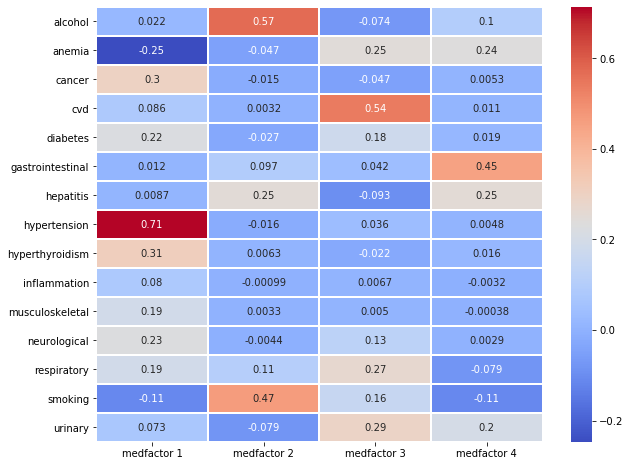

In [337]:
## HEATMAP FOR THE MEDICAL HISTORY FACTORS

fig, axes = plt.subplots(1,1, figsize=(10,8))

# display(corrmatrix)
sns.heatmap(medfactors, annot=True, linewidth=1, cmap="coolwarm")
plt.show()

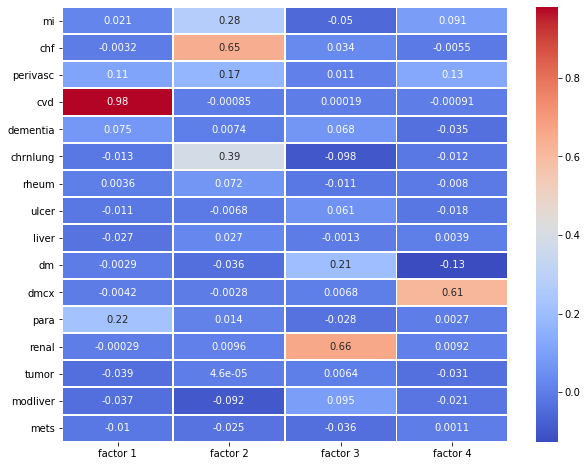

In [338]:
## HEATMAP FOR THE COMORBIDITY FACTORS

fig, axes = plt.subplots(1,1, figsize=(10,8))

# display(corrmatrix)
sns.heatmap(cmbfactors, annot=True, linewidth=1, cmap="coolwarm")
plt.show()

Please note the abbreviations mean the following:

mi
* "Myocardial infarction"

chf
* "Congestive heart failure"

perivasc
* "Peripheral vascular disorders"

cvd
* "Cerebrovascular disease"

dementia
* "Dementia"

chrnlung
* "Chronic pulmonary disease"

rheum
* "Rheumatic disease"

ulcer
* "Peptic ulcer disease"

liver
* "Mild liver disease"

dm
* "Diabetes without chronic complication"

dmcx
* "Diabetes with chronic complication"

para
* "Hemiplegia or paraplegia"

renal
* "Renal disease"

tumor
* "Any malignancy, including lymphoma and leukemia, except malignant neoplasm of skin"

modliver
* "Moderate or severe liver disease"

mets
* "Metastatic solid tumor"

aids
* "AIDS/HIV"

* Examine the missing data proportions if the combined dataset above

(0, 1)

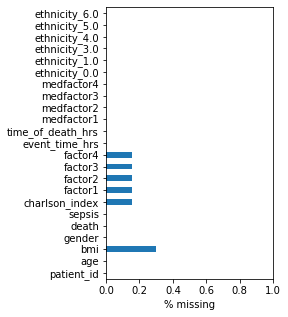

In [7]:
# Missing data (before imputation)
import matplotlib.pyplot as plt
import numexpr as ne

fig, ax = plt.subplots(1,1, figsize=(3,5))
(demog.isna().sum()/len(demog)).plot(kind="barh", ax=ax)
ax.set_xlabel("% missing")
ax.set_xlim(0,1)

# PHASE 2: EXPLORATORY DATA ANALYSIS

### Visualisations to explore relationship between sepsis and demographic variables
* Below I have conducted some exploratory data analysis using plots to examine which variables are associated with sepsis - this informed which variables to put in the Cox regression model

In [8]:
demog.head()
vitals_pivot.head()
# merge these two dataset for the purposes of data visualisation

demogs_vitals = pd.merge(left = demog, right = vitals_pivot, on = 'patient_id')
demogs_vitals["map"] = (demogs_vitals["systolic_bp"] + (2*demogs_vitals["diastolic_bp"]))/3
demogs_vitals = demogs_vitals.groupby("patient_id").agg(np.mean)

* In the plots below, I divided each of the vital signs (averaged across time for each patient) into quintiles, and plotted their relationship with the proportion of sepsis patients
* The plots show how increases in each of the vital signs are associated with the likelihood of sepsis

In [9]:
idx = pd.IndexSlice

def get_normed_crosstab_v2(iv,dv):
    crosstab = pd.crosstab(iv,dv)
    normed_crosstab = crosstab.div(crosstab.sum(axis=1).values.reshape(crosstab.shape[0],1))
    return normed_crosstab

demogs_vitals['dbp'] = pd.qcut(np.round(demogs_vitals["diastolic_bp"], 0), 5, labels = False)
demogs_vitals['sbp'] = pd.cut(np.round(demogs_vitals["systolic_bp"], 2), 5, duplicates='drop', labels = False)
demogs_vitals['hr'] = pd.qcut(np.round(demogs_vitals["heart_rate"], 0), 5, duplicates='drop', labels = False)
demogs_vitals['rr'] = pd.qcut(np.round(demogs_vitals["respiratory_rate"],2), 5, duplicates='drop', labels = False)
demogs_vitals['spo'] = pd.qcut(np.round(demogs_vitals["spo2"], 0), 5, duplicates='drop',labels = False)
demogs_vitals['mean_ap'] = pd.qcut(np.round(demogs_vitals["map"],2), 5, duplicates='drop',labels = False)
demogs_vitals['temp'] = pd.qcut(np.round(demogs_vitals["temperature"],2), 5, duplicates='drop',labels = False)

# sepsis_by_dbp = get_normed_crosstab_v2(dbp,demogs_vitals["sepsis"])*100
# sepsis_by_sbp = get_normed_crosstab_v2(sbp,demogs_vitals["sepsis"])*100
# sepsis_by_hr = get_normed_crosstab_v2(hr,demogs_vitals["sepsis"])*100
# sepsis_by_rr = get_normed_crosstab_v2(rr,demogs_vitals["sepsis"])*100
# sepsis_by_spo = get_normed_crosstab_v2(spo,demogs_vitals["sepsis"])*100
# sepsis_by_temp = get_normed_crosstab_v2(temp,demogs_vitals["sepsis"])*100

demogs_vitals.loc[:,idx["dbp":"temp"]] = demogs_vitals.loc[:,idx["dbp":"temp"]].replace({0:"1st",
                                                                                        1:"2nd",
                                                                                        2:"3rd",
                                                                                        3:"4th",
                                                                                        4:"5th"})

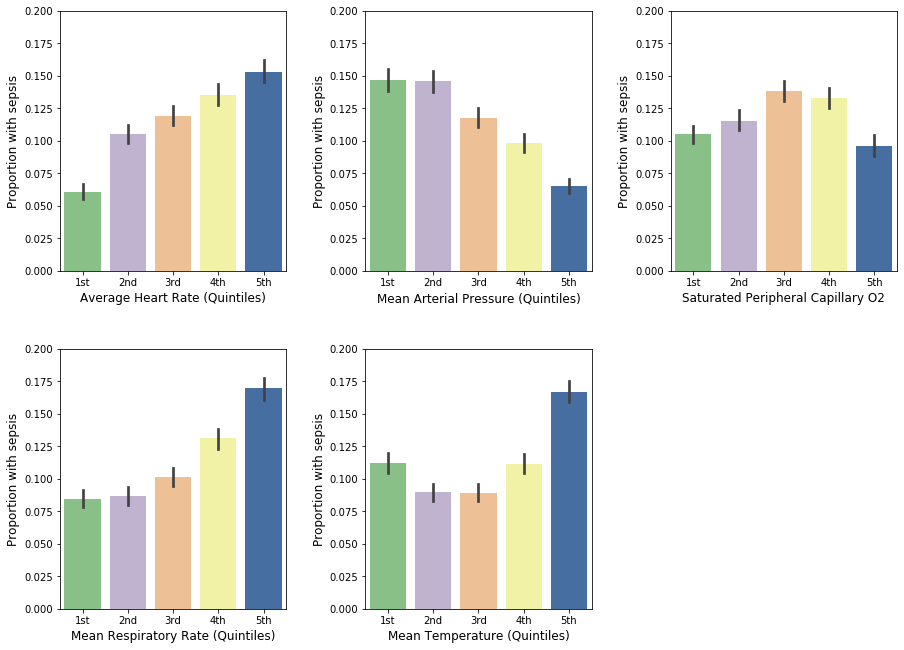

In [25]:
# When using bar plots, the MEAN is the default aggregation

fig, axes = plt.subplots(2,3, figsize=(15,11))
plt.subplots_adjust(hspace = 0.3, wspace=0.35)

sns.barplot(data = demogs_vitals, x = "hr", y = "sepsis", ax=axes[0,0], palette="Accent",
           order = ["1st","2nd","3rd","4th","5th"])
axes[0,0].set_xlabel("Average Heart Rate (Quintiles)", fontsize=12)
axes[0,0].set_ylabel("Proportion with sepsis", fontsize=12)
axes[0,0].set_ylim([0,0.2])

sns.barplot(data = demogs_vitals, x = "mean_ap", y = "sepsis", ax=axes[0,1], palette="Accent",
           order = ["1st","2nd","3rd","4th","5th"])
axes[0,1].set_xlabel("Mean Arterial Pressure (Quintiles)", fontsize=12)
axes[0,1].set_ylabel("Proportion with sepsis", fontsize=12)
axes[0,1].set_ylim([0,0.2])

sns.barplot(data = demogs_vitals, x = "spo", y = "sepsis", ax=axes[0,2], palette="Accent",
           order = ["1st","2nd","3rd","4th","5th"])
axes[0,2].set_xlabel("Saturated Peripheral Capillary O2", fontsize=12)
axes[0,2].set_ylabel("Proportion with sepsis", fontsize=12)
axes[0,2].set_ylim([0,0.2])

sns.barplot(data = demogs_vitals, x = "rr", y = "sepsis", ax=axes[1,0], palette="Accent",
           order = ["1st","2nd","3rd","4th","5th"])
axes[1,0].set_xlabel("Mean Respiratory Rate (Quintiles)", fontsize=12)
axes[1,0].set_ylabel("Proportion with sepsis", fontsize=12)
axes[1,0].set_ylim([0,0.2])

sns.barplot(data = demogs_vitals, x = "temp", y = "sepsis", ax=axes[1,1], palette="Accent",
           order = ["1st","2nd","3rd","4th","5th"])
axes[1,1].set_xlabel("Mean Temperature (Quintiles)", fontsize=12)
axes[1,1].set_ylabel("Proportion with sepsis", fontsize=12)
axes[1,1].set_ylim([0,0.2])

axes[1,2].axis("off")

plt.show()

* In the charts below, I wanted to see if people's comorbidity scores moderated the relationship between vital signs and sepsis (for example, was there a stronger effect of heart rate on sepsis risk, if your CCI score was high?)

In [27]:
# Plots to examine interaction with Charlson comorbidity

demogs_vitals['Charlson'] = pd.qcut(np.round(demogs_vitals["charlson_index"], 0), 2, labels = False)
demogs_vitals['Charlson'] = demogs_vitals['Charlson'].replace({0:"Low CCI score", 1:"High CCI score"})

# First, we need to create two-way contingency tables between sepsis and heart rate
charlson_hr = demogs_vitals.pivot_table(index = "Charlson",
                      columns = "hr",
                      values = "sepsis",
                      aggfunc = np.mean).T

# Second, create two-way contingency tables between sepsis and mean arterial pressure
charlson_map = demogs_vitals.pivot_table(index = "Charlson",
                      columns = "mean_ap",
                      values = "sepsis",
                      aggfunc = np.mean).T

# Third, create two-way contingency tables between sepsis and breathing rate 
charlson_rr = demogs_vitals.pivot_table(index = "Charlson",
                      columns = "rr",
                      values = "sepsis",
                      aggfunc = np.mean).T


In [29]:
# this is how the 2-way tables look like
display(charlson_hr)
display(charlson_map)
display(charlson_rr)

Charlson,High CCI score,Low CCI score
hr,,
1st,0.105042,0.048193
2nd,0.160846,0.088534
3rd,0.178131,0.104356
4th,0.209883,0.119012
5th,0.214559,0.144002


Charlson,High CCI score,Low CCI score
mean_ap,,
1st,0.188873,0.130046
2nd,0.203604,0.132330
3rd,0.184680,0.105314
4th,0.152941,0.087835
5th,0.105365,0.059972


Charlson,High CCI score,Low CCI score
rr,,
1st,0.141771,0.067673
2nd,0.140668,0.073775
3rd,0.151738,0.094223
4th,0.186355,0.116273
5th,0.221588,0.155123


* Now we plot the 2-way interactions between Charlson score, and 3 of the vital signs and sepsis likelihood

Text(0.5, 0, 'Mean Respiratory Rate')

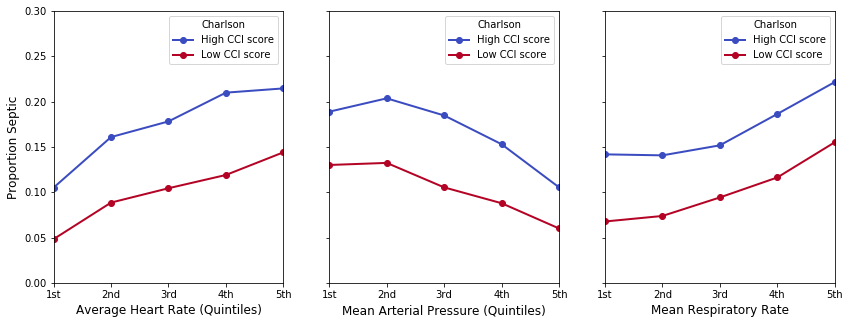

In [31]:
# Now plot the line plots 
# Separate lines 
fig, axes = plt.subplots(1,3, figsize=(14,5))
plt.subplots_adjust(hspace=0.3)

charlson_hr.plot(ax=axes[0], linewidth=2, linestyle="-",cmap="coolwarm", sharey=True, marker = "o")
axes[0].set_ylabel("Proportion Septic", fontsize=12)
axes[0].set_ylim([0,0.3])
axes[0].set_xticks([0,1,2,3,4])
axes[0].set_xticklabels(["1st","2nd","3rd","4th","5th"])
axes[0].set_xlabel("Average Heart Rate (Quintiles)", fontsize=12)

charlson_map.plot(ax=axes[1], linewidth=2, linestyle="-",cmap="coolwarm", marker = "o")
axes[1].set_ylabel("Proportion Septic", fontsize=12)
axes[1].set_ylim([0,0.3])
axes[1].set_xticks([0,1,2,3,4])
axes[1].set_xticklabels(["1st","2nd","3rd","4th","5th"])
axes[1].set_xlabel("Mean Arterial Pressure (Quintiles)", fontsize=12)

charlson_rr.plot(ax=axes[2], linewidth=2, linestyle="-",cmap="coolwarm", marker = "o")
axes[2].set_ylabel("Proportion Septic", fontsize=12)
axes[2].set_ylim([0,0.3])
axes[2].set_xticks([0,1,2,3,4])
axes[2].set_xticklabels(["1st","2nd","3rd","4th","5th"])
axes[2].set_xlabel("Mean Respiratory Rate", fontsize=12)

* Noticeable from this chart is that in all cases - higher Charlson comorbidity score is related to a greater risk of sepsis (blue lines are higher than the red lines)
* Subtle, yet visible - there is a sharper increase in the heart-rate curve, and a faster decrease in the blood pressure curve among those with HIGH Charlson scores (blue lines) versus low Charlson scores (red lines)
* For respiration rate, the risk of sepsis changes in a more rapid (exponential) fashion among those with HIGH Charlson scores, compared to those with low Charlson scores

### Examining changes in vital signs

In [37]:
# The charts below were formed from the dataset "cox_train_oneline", which we will create below (in the subsequent steps)
# I added the charts here, though, to keep all charts together
# In case you want to create the plots now, the file is:

cox_train_oneline = pd.read_csv("cox_oneline.csv")

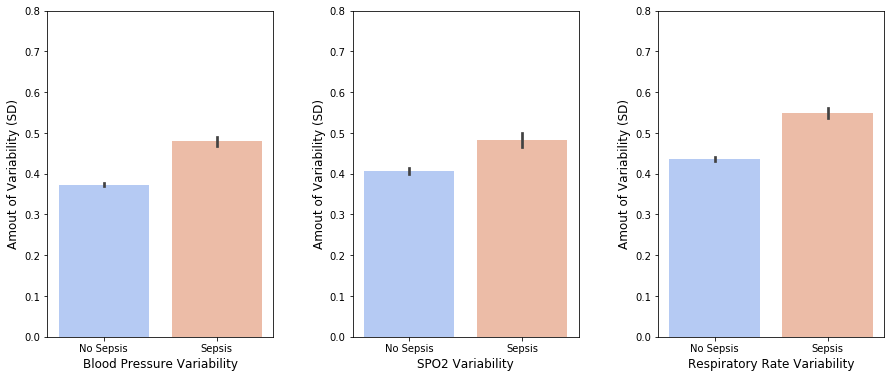

In [38]:
# When using bar plots, the MEAN is the default aggregation

fig, axes = plt.subplots(1,3, figsize=(15,6))

plt.subplots_adjust(wspace=0.35)
sns.barplot(data = cox_train_oneline, x = "sepsis", y = "map_sd", ax=axes[0], palette="coolwarm")
axes[0].set_xlabel("Blood Pressure Variability", fontsize=12)
axes[0].set_xticklabels(["No Sepsis","Sepsis"])
axes[0].set_ylabel("Amout of Variability (SD)", fontsize=12)
axes[0].set_ylim([0,0.8])

sns.barplot(data = cox_train_oneline, x = "sepsis", y = "spo2_sd", ax=axes[1], palette="coolwarm")
axes[1].set_xlabel("SPO2 Variability", fontsize=12)
axes[1].set_xticklabels(["No Sepsis","Sepsis"])
axes[1].set_ylabel("Amout of Variability (SD)", fontsize=12)
axes[1].set_ylim([0,0.8])

sns.barplot(data = cox_train_oneline, x = "sepsis", y = "respiratory_rate_sd", ax=axes[2], palette="coolwarm")
axes[2].set_xlabel("Respiratory Rate Variability", fontsize=12)
axes[2].set_ylabel("Amout of Variability (SD)", fontsize=12)
axes[2].set_xticklabels(["No Sepsis","Sepsis"])
axes[2].set_ylim([0,0.8])


plt.show()

* Below I have added some additional plots - here the vital signs are along the Y-axis (their mean), and the X-axis are the sepsis/no-sepsis groups. It is hard to see any group differences here because of the large amount of outliers
* But we can see average heart rate and SPO2 appears to be higher among sepsis patients (slightly)

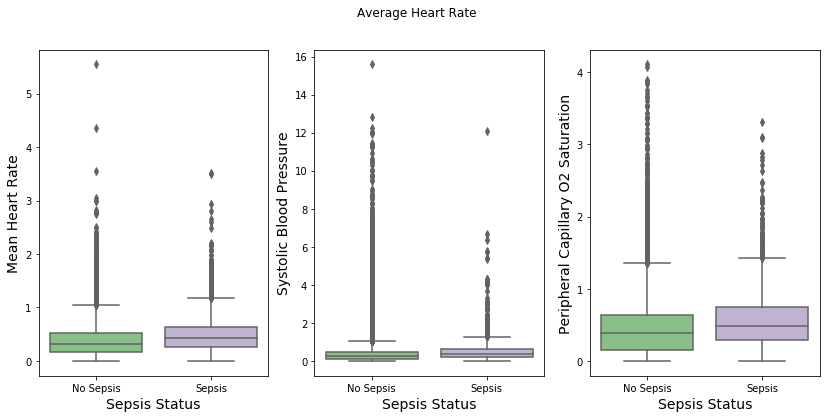

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(14,6))
plt.subplots_adjust(hspace = 0.3)

fig1 = sns.boxplot(data = cox_train_oneline, x = "sepsis", y = "map_sd", ax = axes[0], palette='Accent')
plt.suptitle("Average Heart Rate")
axes[0].set_ylabel("Mean Heart Rate", fontsize=14)
axes[0].set_xlabel("Sepsis Status", fontsize=14)
axes[0].set_xticklabels(["No Sepsis","Sepsis"])

fig2 = sns.boxplot(data = cox_train_oneline, x = "sepsis", y = "spo2_sd", ax = axes[1], palette='Accent')
axes[1].set_ylabel("Systolic Blood Pressure", fontsize=14)
axes[1].set_xlabel("Sepsis Status", fontsize=14)
axes[1].set_xticklabels(["No Sepsis","Sepsis"])

fig3 = sns.boxplot(data = cox_train_oneline, x = "sepsis", y = "respiratory_rate_sd", ax = axes[2], palette='Accent')
axes[2].set_ylabel("Peripheral Capillary O2 Saturation", fontsize=14)
axes[2].set_xlabel("Sepsis Status", fontsize=14)
axes[2].set_xticklabels(["No Sepsis","Sepsis"])
plt.show()

# PHASE 3: IMPUTATION OF MISSING DATA AND FEATURE ENGINEERING

### Impute missing data (and standardise) both the demographics and vital signs datasets
* Created a function below that imputes missing data to the training data
* Then uses the same algorithm to impute the missing data to the testing data >> so the training imputation model is fitted to the test data to fill in missing data

In [44]:
list(demog.columns)

['patient_id',
 'age',
 'bmi',
 'gender',
 'death',
 'sepsis',
 'charlson_index',
 'factor1',
 'factor2',
 'factor3',
 'factor4',
 'event_time_hrs',
 'time_of_death_hrs',
 'medfactor1',
 'medfactor2',
 'medfactor3',
 'medfactor4',
 'ethnicity_0.0',
 'ethnicity_1.0',
 'ethnicity_3.0',
 'ethnicity_4.0',
 'ethnicity_5.0',
 'ethnicity_6.0']

In [45]:
# Impute demographics for the training and testing data

def impute_demographics(training_data = train, testing_data=test):
    train_demographics = train.drop(["age","bmi","charlson_index","patient_id"], axis=1).reset_index(drop=True)
    test_demographics = test.drop(["age","bmi","charlson_index","patient_id"], axis=1).reset_index(drop=True)
    
    scale = StandardScaler()
    scaled_train = scale.fit_transform(train[["age","bmi","charlson_index"]])
    scaled_train_df = pd.DataFrame(scaled_train, columns=["age","bmi","charlson_index"])
    scaled_test = scale.fit_transform(test[["age","bmi","charlson_index"]])
    scaled_test_df = pd.DataFrame(scaled_test, columns=["age","bmi","charlson_index"])
    
    # Return these columns to the training and testing data
    train_demographics = pd.concat([train_demographics, scaled_train_df], axis=1)
    test_demographics = pd.concat([test_demographics, scaled_test_df], axis=1)

    # We will do five imputations - this for loop will perform 40 imputations and average these imputations
    # To get a final dataset
    train_imputations = []
    test_imputations = []
    imputations = 40

    for i in range(imputations):
        imputer = IterativeImputer(initial_strategy='mean', 
                                   max_iter=100,
                                   min_value=0,
                                   missing_values=np.nan,
                                   random_state=i)    
        train_imputations.append(imputer.fit_transform(train_demographics))
        test_imputations.append(imputer.transform(test_demographics))

    # Aggregate imputed datasets into a final training imputed dataset    
    train_imputations_averaged = sum(train_imputations)/40
    test_imputations_averaged = sum(test_imputations)/40
    train_imputed = pd.DataFrame(train_imputations_averaged, columns = train_demographics.columns, 
                                        index = train['patient_id'])
    test_imputed = pd.DataFrame(test_imputations_averaged, columns = test_demographics.columns, 
                                        index = test['patient_id'])
    train_imputed.reset_index(inplace=True)
    test_imputed.reset_index(inplace=True)
    trainids = train_imputed['patient_id'].values
    testids = test_imputed['patient_id'].values
    
    return train_imputed, test_imputed, trainids, testids, scale


In [46]:
# timedelta(hours=43880.6543)

In [47]:
# Apply missing data function to fill in missing data
# Return the filled testing and training datasets, and the train and test list of IDS
# Also return the scaler object "input_demographics" so we can back transform the data later on

train_imputed, test_imputed, trainids, testids, demographics_scaler = impute_demographics()

In [48]:
# Examine descriptives after imputation
# There are NO unusual values!!

train_imputed.describe()

,gender,death,sepsis,factor1,factor2,factor3,factor4,event_time_hrs,time_of_death_hrs,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,ethnicity_6.0,age,bmi,charlson_index
count,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000
mean,0.454373,0.083114,0.113520,0.024703,-0.013130,-0.001701,-0.010250,73.432889,92.045782,-0.000249,-0.002504,0.000068,0.000342,0.071215,0.019565,0.038728,0.108629,0.004161,0.000073,0.000002,0.012694,0.009384
std,0.497923,0.276060,0.317233,0.924178,0.677401,0.597343,0.666171,82.352302,113.794924,0.798253,0.706253,0.697569,0.607914,0.257188,0.138502,0.192950,0.311179,0.064374,0.008544,0.999726,0.817657,0.922190
min,0.000000,0.000000,0.000000,-0.402600,-0.853396,-0.693334,-0.635627,4.000000,0.000000,-1.621887,-0.706648,-1.195319,-0.618661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.707784,-2.752269,-0.880373
25%,0.000000,0.000000,0.000000,-0.353102,-0.509795,-0.198653,-0.430495,21.000000,25.933333,-0.533510,-0.225085,-0.608912,-0.238307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.617577,-0.403343,-0.880373
50%,0.000000,0.000000,0.000000,-0.352667,-0.119248,-0.198653,-0.320071,43.000000,51.000000,-0.344934,-0.151834,-0.300504,-0.233123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094059,0.000000,-0.084944
75%,1.000000,0.000000,0.000000,0.000000,0.058265,0.034183,0.090317,93.000000,113.554167,0.424334,-0.133357,0.510184,-0.161805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.778120,0.264146,0.312770
max,1.000000,1.000000,1.000000,2.840951,2.960218,4.412162,2.838644,478.500000,2747.666667,3.367469,5.659476,2.901548,5.288197,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.804210,2.719929,5.880772


In [49]:
# View the first 5 rows of the training data
train_imputed.head()

,patient_id,gender,death,sepsis,factor1,factor2,factor3,factor4,event_time_hrs,time_of_death_hrs,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,ethnicity_6.0,age,bmi,charlson_index
0,!!AScBQ5btA,0.0,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,69.00,69.00,-0.533510,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373
1,!!G4BY3c@tP,0.0,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,14.90,14.90,-0.704932,2.310438,-0.843335,0.582433,0.0,0.0,0.0,0.0,0.0,0.0,-0.423578,0.000000,-0.880373
2,!!SGlv5II!P,1.0,0.0,1.0,-0.353102,-0.509795,-0.198653,-0.430495,4.75,27.75,-0.344934,-0.133357,0.291901,-0.180172,0.0,0.0,0.0,0.0,0.0,0.0,0.437724,-0.336676,-0.880373
3,!!rmvMcfsDP,1.0,0.0,0.0,2.720469,1.126702,0.136875,0.481550,302.00,302.00,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,0.0,0.292070,0.426203,0.710485
4,!0KLAkVXUQU,1.0,0.0,0.0,-0.358990,0.256240,3.778535,1.934842,13.50,13.50,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,0.0,-0.707723,0.138286,1.108199


### Function to get rid of all vital measurements that occurred after sepsis and death

In [50]:
def remove_negative_vital_times(vitals = vitals_pivot, demog_vitals = demog[['patient_id','event_time_hrs','sepsis','death']]):  
    
    # Merge the data - this will be an inner join - anyone NOT in the clean demographics data will be removed
    merged = pd.merge(vitals, demog_vitals, on='patient_id')
    invalid_time_points = np.where(
        (merged['time_hrs'] > merged['event_time_hrs'])
                                                 & 
        (merged["sepsis"] == 1),True, False)

    # Repeat the same above for people that died (and did not experience sepsis)

    invalid_time_points_death = np.where(
        (merged['time_hrs'] > merged['event_time_hrs'])
                                                 & 
        (merged["death"] == 1),True, False)
    
    ## filter the dataframe using these filters (combined) to get rid of all invalid records
    invalid_filter = invalid_time_points + invalid_time_points_death
    merged = merged[~invalid_filter]
    
    merged.drop(['event_time_hrs','sepsis','death',
                'vitals_time','start','end','end_minus_start','time'], axis=1, inplace=True)
    
    return merged

In [51]:
vitals_pivot_cleaned = remove_negative_vital_times()
vitals_pivot_cleaned.head()

,patient_id,diastolic_bp,heart_rate,respiratory_rate,spo2,systolic_bp,temperature,time_hrs
0,!!AScBQ5btA,84.0,115.0,29.0,100.0,125.0,37.211111,0.00
1,!!AScBQ5btA,90.0,117.0,30.0,100.0,127.0,NaN,0.25
2,!!AScBQ5btA,85.0,110.0,26.0,100.0,126.0,NaN,0.50
3,!!AScBQ5btA,80.0,106.0,25.0,100.0,121.0,NaN,0.75
4,!!AScBQ5btA,82.0,109.0,24.0,100.0,129.0,NaN,1.00


In [52]:
# Which columns are missing data, the percent of total rows
((vitals_pivot_cleaned.isna().sum()) / len(vitals_pivot_cleaned))*100

# Temperature - EXTREME missing data - Probably will not use this column

patient_id           0.000000
diastolic_bp        28.501015
heart_rate          13.486526
respiratory_rate    17.408155
spo2                21.730309
systolic_bp         28.473978
temperature         74.977053
time_hrs             0.000000
dtype: float64

In [53]:
len(vitals_pivot_cleaned.patient_id.unique())

36528

In [54]:
# Function to split the vitals data into train and test using the same IDs as in the demographics splits
# Then impute missing data on both using forward filling and imputation

def impute_missing_vitals(data = vitals_pivot_cleaned, trainids = trainids, testids = testids):
    data = data.drop("temperature", axis=1)
    
    # Convert time-hrs to time_delta so we can use it as a datetime index, to resample the data
    data['time'] = pd.to_timedelta(data['time_hrs'], unit='h')

    # Before resampling, will calculate "mean arterial pressure"
    data["map"] = (data["systolic_bp"] + (2*data["diastolic_bp"]))/3
    
    # We will drop both systolic and diastolic - these are VERY collinear
    data = data.drop(["systolic_bp","diastolic_bp"], axis=1)
    
    # resample to hourly, and pad the values with NANS
    data = data.set_index("time").groupby("patient_id").resample("1H").mean().groupby(level=0).apply(lambda x: x.interpolate()).reset_index()

    # Fill in remaining missing values with last value carried forwards
    data_filled = data.fillna(data.groupby("patient_id").transform("ffill"))
    
    # Drop time column, it is no longer needed (if needed, we can calculate it later)
    data_filled = data_filled.drop(["time"], axis=1)
    
    # Split into train and test sets
    train_vitals = data_filled.loc[data["patient_id"].isin(trainids),:]
    test_vitals = data_filled.loc[data["patient_id"].isin(testids),:]

    
    # Scale this data - "patient_id")[[''time_hrs','heart_rate','respiratory_rate','map','spo2'
    scale_train = StandardScaler()
    scale_test = StandardScaler()
    train_vitals_to_scale = train_vitals[['heart_rate','respiratory_rate','map','spo2']]
    test_vitals_to_scale = test_vitals[['heart_rate','respiratory_rate','map','spo2']]
    train_vitals_scaled = scale_train.fit_transform(train_vitals_to_scale)
    test_vitals_scaled = scale_test.fit_transform(test_vitals_to_scale)
    
    train_vitals_df = pd.DataFrame(train_vitals_scaled, columns = ['heart_rate','respiratory_rate','map','spo2'])
    test_vitals_df = pd.DataFrame(test_vitals_scaled, columns = ['heart_rate','respiratory_rate','map','spo2'])
    train_vitals_for_impute = pd.concat([train_vitals[["time_hrs"]].reset_index(drop=True), train_vitals_df], axis=1)    
    test_vitals_for_impute = pd.concat([test_vitals[["time_hrs"]].reset_index(drop=True), test_vitals_df], axis=1)
    
    # Perform imputations
    
    # We will do five imputations - this for loop will perform 10 imputations and average these imputations
    # To get a final dataset
    train_imputations = []
    test_imputations = []
    imputations = 10

    for i in range(imputations):
        imputer = IterativeImputer(initial_strategy='mean', 
                                   max_iter=100,
                                   missing_values=np.nan,
                                   random_state=i)    
        train_imputations.append(imputer.fit_transform(train_vitals_for_impute))
        test_imputations.append(imputer.transform(test_vitals_for_impute))

    # Aggregate imputed datasets into a final training imputed dataset    
    train_imputations_averaged = sum(train_imputations)/10
    test_imputations_averaged = sum(test_imputations)/10
    train_imputed = pd.DataFrame(train_imputations_averaged, columns = ['time_hrs','heart_rate','respiratory_rate','map','spo2'],
                                index = train_vitals.patient_id)
    test_imputed = pd.DataFrame(test_imputations_averaged, columns = ['time_hrs','heart_rate','respiratory_rate','map','spo2'],
                               index = test_vitals.patient_id)
    train_imputed.reset_index(inplace=True)
    test_imputed.reset_index(inplace=True)
    
    return train_imputed, test_imputed, scale_train, scale_test

In [55]:
# vitals_train, vitals_test, scale_train, scale_test = impute_missing_vitals(vitals_pivot_short, sample_train_ids, sample_test_ids)
# vitals_train

In [56]:
# Now apply the function to the vitals data to get imputed vital signs data - both training and testing

vitals_train, vitals_test, vitals_scale_train, vitals_scale_test = impute_missing_vitals()

In [57]:
# View the datasets - training

display(vitals_train.head())
display(vitals_train.describe())

,time_hrs,heart_rate,respiratory_rate,map,spo2
count,1.976601e+06,1.976601e+06,1.976601e+06,1.976601e+06,1.976601e+06
mean,8.088049e+01,-2.294921e-04,-3.331891e-04,-1.180368e-04,9.966581e-04
std,8.359755e+01,9.917762e-01,9.788466e-01,9.867610e-01,9.556297e-01
min,0.000000e+00,-4.848149e+00,-3.684514e+00,-5.663147e+00,-3.025707e+01
25%,1.964762e+01,-7.065011e-01,-6.548795e-01,-7.012587e-01,-4.735816e-01
50%,5.102500e+01,-6.483733e-02,-1.499403e-01,-4.811706e-02,1.014661e-01
75%,1.143333e+02,6.351596e-01,4.054927e-01,6.167472e-01,6.353781e-01
max,4.783042e+02,1.142678e+01,1.004983e+01,1.409282e+01,1.110646e+00


In [58]:
# View the datasets - testing

display(vitals_test.head())
display(vitals_test.describe()

,time_hrs,heart_rate,respiratory_rate,map,spo2
count,652187.000000,652187.000000,652187.000000,652187.000000,652187.000000
mean,79.929999,-0.000288,-0.000089,0.000011,0.000679
std,82.883942,0.991161,0.977503,0.985142,0.950830
min,0.000000,-4.738497,-3.651917,-5.272213,-29.712070
25%,19.425000,-0.697440,-0.656728,-0.682622,-0.460218
50%,50.450000,-0.062417,-0.124250,-0.049866,0.093671
75%,112.625000,0.630336,0.441508,0.608762,0.603541
max,479.233333,8.414181,9.926273,11.781265,1.095732


### Calculate rolling statistics and time-shifted variables
* Now we will calculate rolling statistics - i.e., 6hr means and 6hr standard deviations over 6 hr sliding windows
* We will also calculate 'shifted' variables - which quantify how much each vital sign has changed relative to the same value 6 hours ago - so negative values mean the vital sign value decreased, and positive values mean that the vtial sign value has increased

In [61]:
# Vew the current columns in the vitals dataset
vitals_train.columns

Index(['patient_id', 'time_hrs', 'heart_rate', 'respiratory_rate', 'map', 'spo2'], dtype='object')

In [62]:
# Calculate function to get the 6hr difference - this will be used to get "shifted" values

def six_hr_delay(series):
    difference = series - series.shift(5)
    return difference

cols_to_shift = ['heart_rate', 'respiratory_rate', 'map', 'spo2']
vitals_train[['heart_rate_shift', 'respiratory_rate_shift', 'map_shift', 'spo2_shift']] = vitals_train.groupby("patient_id")[cols_to_shift].apply(six_hr_delay)
vitals_test[['heart_rate_shift', 'respiratory_rate_shift', 'map_shift', 'spo2_shift']] = vitals_test.groupby("patient_id")[cols_to_shift].apply(six_hr_delay)


In [63]:
# train_roll = vitals_train.iloc[:10000,:]
# train_roll.groupby("patient_id")[cols_to_shift].rolling(6).mean()

In [64]:
# Now calculate rolling means and standard deviations
# Get rolling means
train_rolling = vitals_train.groupby("patient_id")[cols_to_shift].rolling(6).mean()
train_rolling = train_rolling.reset_index(drop=True)
train_rolling.columns = ["heart_rate_mean","respiratory_rate_mean","map_mean","spo2_mean"]
test_rolling = vitals_test.groupby("patient_id")[cols_to_shift].rolling(6).mean()
test_rolling = test_rolling.reset_index(drop=True)
test_rolling.columns = ["heart_rate_mean","respiratory_rate_mean","map_mean","spo2_mean"]

# Get rolling standard deviations
train_rolling_std = vitals_train.groupby("patient_id")[cols_to_shift].rolling(6).std()
train_rolling_std.columns = ["heart_rate_sd","respiratory_rate_sd","map_sd","spo2_sd"]
train_rolling_std = train_rolling_std.reset_index(drop=True)
test_rolling_std = vitals_test.groupby("patient_id")[cols_to_shift].rolling(6).std()
test_rolling_std.columns = ["heart_rate_sd","respiratory_rate_sd","map_sd","spo2_sd"]
test_rolling_std = test_rolling_std.reset_index(drop=True)

In [65]:
# Merge these variables with the original vital signs data (both training and testing)
vitals_train_final = pd.concat([vitals_train, train_rolling, train_rolling_std], axis=1)
vitals_test_final = pd.concat([vitals_test, test_rolling, test_rolling_std], axis=1)

In [66]:
# Examine missing data
# There is missing data because to calculate rolling 6hr windows - the first 5 hours are skipped
# Leading to missing data
# We will drop these rows
# This is not problematic since all participants with sepsis in the first 4h were not included
vitals_train_final.isna().sum()

patient_id                     0
time_hrs                       0
heart_rate                     0
respiratory_rate               0
map                            0
spo2                           0
heart_rate_shift          136615
respiratory_rate_shift    136615
map_shift                 136615
spo2_shift                136615
heart_rate_mean           136615
respiratory_rate_mean     136615
map_mean                  136615
spo2_mean                 136615
heart_rate_sd             136615
respiratory_rate_sd       136615
map_sd                    136615
spo2_sd                   136615
dtype: int64

# PHASE 4: FEATURE SELECTION

# Examination of collinearity
* I will join the demographics and vital signs datasets together so we can examine whether the features are independent, or collinear (highly correlated) with one another.
* Survival models do not converge when covariates (feature) are highly collinear.

In [67]:
# Merge the datasets and we drop the nas - these will be the first few rows which are missing values
# Because of the rolling average window being 6 hours long. 
# The first five hours of each person will be missing

train_full = pd.merge(vitals_train_final, train_imputed, on = "patient_id", how="left").dropna()
test_full = pd.merge(vitals_test_final, test_imputed, on = "patient_id", how="left").dropna()

* Below are all the columns I tested for collinearity


In [71]:
# List the columns to test collinearity

list(train_full.columns)

# Columns to train for collinearity testing

vifcols = [
 'heart_rate',
 'respiratory_rate',
 'map',
 'spo2',
 'heart_rate_shift',
 'respiratory_rate_shift',
 'map_shift',
 'spo2_shift',
 'heart_rate_mean',
 'respiratory_rate_mean',
 'map_mean',
 'spo2_mean',
 'heart_rate_sd',
 'respiratory_rate_sd',
 'map_sd',
 'spo2_sd',
 'gender',
 'factor1',
 'factor2',
 'factor3',
 'factor4',
 'medfactor1',
 'medfactor2',
 'medfactor3',
 'medfactor4',
 'ethnicity_0.0',
 'ethnicity_1.0',
 'ethnicity_3.0',
 'ethnicity_4.0',
 'ethnicity_5.0',
 'ethnicity_6.0',
 'age',
 'bmi',
 'charlson_index'
    ]

train_subset = train_full[vifcols]

* Now I will calculate the Variance Inflation Factor of all predictors
* Those with VIFs above 10 are highly correlated with the others and should be removed

In [72]:
# !pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get the variance inflation factors

vifs = []
for i in range(len(train_subset.columns)):    
    vif = variance_inflation_factor(train_subset.values, i)    
    vifs.append(vif)    
vif_df = pd.DataFrame(vifs, index = train_subset.columns, columns = ["VIF"])

display(vif_df)

# The heart rate mean and heart rate columns have the highest VIF
# Will delete the heart_rate column (as shown above) and this almost eliminates all multicollinearity (except map)

,VIF
heart_rate,30.155741
respiratory_rate,10.213350
map,15.117749
spo2,11.028327
heart_rate_shift,3.965710
respiratory_rate_shift,3.079564
map_shift,3.317791
spo2_shift,3.368465
heart_rate_mean,27.570208
respiratory_rate_mean,8.310022


* Having tested collinearity - heart rate was very collinear (very high VIF) so it will be removed
* Map and map_mean were also high, but I will keep these in, because they do not lead to convergence problems of the model

In [73]:
# List the final columns to include in the modelling, after removing collinear columns

finalcols = [
'patient_id',
 'time_hrs',
#  'heart_rate', # Note - this is removed
 'respiratory_rate',
 'map',
 'spo2',
 'heart_rate_shift',
 'respiratory_rate_shift',
 'map_shift',
 'spo2_shift',
 'heart_rate_mean',
 'respiratory_rate_mean',
 'map_mean',
 'spo2_mean',
 'heart_rate_sd',
 'respiratory_rate_sd',
 'map_sd',
 'spo2_sd',
 'gender',
 'sepsis',
 'factor1',
 'factor2',
 'factor3',
 'factor4',
 'event_time_hrs',
 'medfactor1',
 'medfactor2',
 'medfactor3',
 'medfactor4',
 'ethnicity_0.0',
 'ethnicity_1.0',
 'ethnicity_3.0',
 'ethnicity_4.0',
 'ethnicity_5.0',
 'ethnicity_6.0',
 'age',
 'bmi',
 'charlson_index'
    ]


# Now subset the training dataset using these columns only
# Note, did not include the death data

train_subset = train_full[finalcols]

## Preliminary Feature Selection
* Based on "A comparative study of machine learning methods for time-to-event survival data for radiomics risk modelling - *Scientific Reports* volume 7, Article number: 13206 (2017)" - I performed feature selection using Spearman feature selection

In [74]:
# Columns to test for feature selection - these are the columns that were least collinear 

finalcols = [
'patient_id',
 'time_hrs',
#  'heart_rate',
 'respiratory_rate',
 'map',
 'spo2',
 'heart_rate_shift',
 'respiratory_rate_shift',
 'map_shift',
 'spo2_shift',
 'heart_rate_mean',
 'respiratory_rate_mean',
 'map_mean',
 'spo2_mean',
 'heart_rate_sd',
 'respiratory_rate_sd',
 'map_sd',
 'spo2_sd',
 'gender',
#  'death',
 'sepsis',
 'factor1',
 'factor2',
 'factor3',
 'factor4',
 'event_time_hrs',
#  'time_of_death_hrs',
 'medfactor1',
 'medfactor2',
 'medfactor3',
 'medfactor4',
 'ethnicity_0.0',
 'ethnicity_1.0',
 'ethnicity_3.0',
 'ethnicity_4.0',
 'ethnicity_5.0',
 'ethnicity_6.0',
 'age',
 'bmi',
 'charlson_index'
    ]


cox_train_tc = train_full[finalcols].reset_index(drop=True)
cox_test_tc = test_full[finalcols].reset_index(drop=True)
cox_train.shape

(35518, 42)

* Below, perform KBEST feature selection - select the 30 best features, based on strength of association between each predictor and sepsis (using Spearman correlation)

In [75]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import spearmanr

def get_spearmanr(x, y):
    x = np.array(x)
    n_columns = x.shape[1]
    spearman_results = np.empty(n_columns)
    for i in range(n_columns):    
        x_subset = x[:,i:i+1]    
        spearman_correlation = spearmanr(x_subset, y)[0]   
        spearman_results[i] = spearman_correlation   
    return spearman_results

y = cox_train_tc['sepsis']
X = cox_train_tc.drop(["sepsis","event_time_hrs","patient_id","time_hrs"], axis = 1)    
skbspearman = SelectKBest(get_spearmanr, k = 30)
skbspearman.fit(X, y)
skbspearman.get_support()

# Which columns were significant? 
list(X.columns[skbspearman.get_support()])

['respiratory_rate',
 'spo2',
 'heart_rate_shift',
 'respiratory_rate_shift',
 'map_shift',
 'spo2_shift',
 'heart_rate_mean',
 'respiratory_rate_mean',
 'spo2_mean',
 'heart_rate_sd',
 'respiratory_rate_sd',
 'map_sd',
 'spo2_sd',
 'gender',
 'factor1',
 'factor2',
 'factor3',
 'factor4',
 'medfactor2',
 'medfactor3',
 'medfactor4',
 'ethnicity_0.0',
 'ethnicity_1.0',
 'ethnicity_3.0',
 'ethnicity_4.0',
 'ethnicity_5.0',
 'ethnicity_6.0',
 'age',
 'bmi',
 'charlson_index']

* Based on the feature selection above - I will keep all columns
* The number of features is low relative to samples, so we will leave these in

In [76]:
['patient_id','sepsis','time_hrs','event_time_hrs'
    'respiratory_rate',
 'map',
 'spo2',
 'heart_rate_shift',
 'respiratory_rate_shift',
 'map_shift',
 'spo2_shift',
 'heart_rate_mean',
 'respiratory_rate_mean',
 'spo2_mean',
 'heart_rate_sd',
 'respiratory_rate_sd',
 'map_sd',
 'spo2_sd',
 'gender',
 'factor1',
 'factor2',
 'factor3',
 'factor4',
 'medfactor2',
 'medfactor3',
 'medfactor4',
 'ethnicity_0.0',
 'ethnicity_1.0',
 'ethnicity_3.0',
 'ethnicity_4.0',
 'ethnicity_5.0',
 'age',
 'bmi',
 'charlson_index']

cox_train_tc = train_full[finalcols].reset_index(drop=True)
cox_test_tc = test_full[finalcols].reset_index(drop=True)
cox_train.shape

(35518, 42)

# PRELIMINARY FITTING COX REGRESSION
* The sections below include data preparation steps to perform Cox regression
* The first type of Cox regression we will use is Cox regression with time-varying variables
* This model accounts for time-varying features (varying WITHIN each person)
* I am just performing some preliminary model fitting to see whether the model converges. Also to extract significant features (statistically significant), remove those features with very high standard errors, and using getting the feature importance in the metric of risk ratios.

#### Essential data preparation steps to do time-varying Cox regression

In [77]:
# The first step to preparing the data is to make a "start" column, which marks
# when each measurement interval started

cox_train_tc['start_time_hrs'] = cox_train_tc.groupby('patient_id')['time_hrs'].shift(1)
cox_train_tc['start_time_hrs'] = cox_train_tc['start_time_hrs'].replace({np.nan:0})

# Now, make peoples final row for time_hrs column be their event time value (i.e., when sepsis occurred, or were censored)
# Patients' final row is the row where that identifies their MAXIMUM measurement time (time_hrs) 

cox_train_tc["max_time"] = cox_train_tc.groupby("patient_id")["time_hrs"].transform(np.max)
cox_train_tc["time_hrs"] = np.where(cox_train_tc["time_hrs"] == cox_train_tc["max_time"],cox_train_tc["event_time_hrs"],cox_train_tc["time_hrs"])

# Delete max_time, as this is NOT needed in the analysis
cox_train_tc = cox_train_tc.drop("max_time", axis=1)

# Check that start time is ALWAYS less than time hours (event_time) and NOT be equal to or greater than event time
# Count how many rows have this violation (none, as shown below)
display((cox_train_tc['start_time_hrs'] >= cox_train_tc['time_hrs']).sum())

# Make people's sepsis status coded on their final row
cox_train_tc["sepsis_event"] = np.where((cox_train_tc["event_time_hrs"] == cox_train_tc["time_hrs"]),
                                     cox_train_tc["sepsis"], 0)
# Drop unneeded columns
cox_train_tc = cox_train_tc.drop(["event_time_hrs","sepsis"], axis=1)

# Check missing values
display(cox_train_tc.isna().sum()) # NONE!

# View final list of columns
display(cox_train_tc.columns)

0

patient_id                0
time_hrs                  0
respiratory_rate          0
map                       0
spo2                      0
heart_rate_shift          0
respiratory_rate_shift    0
map_shift                 0
spo2_shift                0
heart_rate_mean           0
respiratory_rate_mean     0
map_mean                  0
spo2_mean                 0
heart_rate_sd             0
respiratory_rate_sd       0
map_sd                    0
spo2_sd                   0
gender                    0
factor1                   0
factor2                   0
factor3                   0
factor4                   0
medfactor1                0
medfactor2                0
medfactor3                0
medfactor4                0
ethnicity_0.0             0
ethnicity_1.0             0
ethnicity_3.0             0
ethnicity_4.0             0
ethnicity_5.0             0
ethnicity_6.0             0
age                       0
bmi                       0
charlson_index            0
start_time_hrs      

Index(['patient_id', 'time_hrs', 'respiratory_rate', 'map', 'spo2', 'heart_rate_shift', 'respiratory_rate_shift', 'map_shift', 'spo2_shift', 'heart_rate_mean', 'respiratory_rate_mean', 'map_mean', 'spo2_mean', 'heart_rate_sd', 'respiratory_rate_sd', 'map_sd', 'spo2_sd', 'gender', 'factor1', 'factor2', 'factor3', 'factor4', 'medfactor1', 'medfactor2', 'medfactor3', 'medfactor4', 'ethnicity_0.0', 'ethnicity_1.0', 'ethnicity_3.0', 'ethnicity_4.0', 'ethnicity_5.0', 'ethnicity_6.0', 'age', 'bmi', 'charlson_index', 'start_time_hrs', 'sepsis_event'], dtype='object')

In [80]:
# !pip install lifelines
from lifelines import CoxPHFitter
from lifelines.utils import to_episodic_format
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(cox_train_tc, id_col="patient_id", event_col="sepsis_event",
        start_col = "start_time_hrs", stop_col = "time_hrs", show_progress=True)

# Will try time varying Cox regression

  Using cached https://files.pythonhosted.org/packages/08/7a/1ccee2a929d806ba3dbe632a196ad6a3f1423d6e261ae887e5fef2011420/autograd-1.2.tar.gz
  Stored in directory: C:\Users\z3160256\AppData\Local\pip\Cache\wheels\72\6f\c2\40f130cca2c91f31d354bf72de282922479c09ce0b7853c4c5
  Stored in directory: C:\Users\z3160256\AppData\Local\pip\Cache\wheels\0c\61\d2\d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built autograd future
Iteration 15: norm_delta = 0.00466, step_size = 1.00000, ll = -24927.34643, newton_decrement = 0.00000, seconds_since_start = 511.4Convergence completed after 15 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 1839986 periods, 26645 subjects, 2592 events>

In [81]:
# Let's view the results
np.round(ctv.summary,2)

,coef,exp(coef),se(coef),z,p,-log2(p),lower 0.95,upper 0.95
respiratory_rate,0.09,1.09,0.05,1.72,0.09,3.54,-0.01,0.19
map,-0.10,0.90,0.06,-1.73,0.08,3.58,-0.22,0.01
spo2,0.04,1.04,0.04,0.98,0.33,1.60,-0.04,0.12
heart_rate_shift,0.04,1.04,0.03,1.38,0.17,2.58,-0.02,0.09
respiratory_rate_shift,-0.05,0.95,0.03,-1.66,0.10,3.37,-0.11,0.01
map_shift,-0.01,0.99,0.04,-0.26,0.80,0.33,-0.08,0.06
spo2_shift,0.01,1.01,0.02,0.61,0.54,0.89,-0.03,0.06
heart_rate_mean,0.28,1.33,0.02,13.22,0.00,130.11,0.24,0.32
respiratory_rate_mean,0.03,1.03,0.05,0.61,0.54,0.89,-0.07,0.14
map_mean,-0.22,0.81,0.06,-3.44,0.00,10.77,-0.34,-0.09


In [82]:
# Which features were significant in the Cox regression?

ctvsummary = ctv.summary
ctv_sig = ctvsummary.loc[ctvsummary['p']<0.10,'p']
ctv_sigcols = list(ctv_sig.index)
display(ctv_sigcols)

['respiratory_rate',
 'map',
 'respiratory_rate_shift',
 'heart_rate_mean',
 'map_mean',
 'spo2_mean',
 'respiratory_rate_sd',
 'map_sd',
 'spo2_sd',
 'gender',
 'factor2',
 'medfactor1',
 'medfactor2',
 'medfactor3',
 'ethnicity_0.0',
 'ethnicity_1.0',
 'ethnicity_5.0',
 'charlson_index']

# 2. Time sliced Cox regression
* This is a variant of Cox regression where each WINDOW is considered the unit of observation
* This method is based on: Mortality Prediction in ICUs Using: A Novel Time-Slicing Cox Regression Method, *AMIA* Annu Symp Proc. 2015 Nov 5;2015:1289-95. eCollection 2015.

In [83]:
# First, prepare the datasets - we need to use slightly different features to code time
# So will revert back to the full training and testing datasets

cox_train_ts = train_full[finalcols].reset_index(drop=True)
cox_test_ts = test_full[finalcols].reset_index(drop=True)
cox_train.shape

(35518, 42)

* The code below will calculate a new column called "sepsis_time_hours"

In [84]:
# We will calculate a new event time (time until sepsis) column
# Which is the difference between the original event_time and the measurement_time
# The reason is, we want rows that are closer to the event time to have a smaller event time
# This is so the model learns the features associated with a short time until sepsis onset

cox_train_ts["sepsis_time_hrs"] = cox_train_ts["event_time_hrs"] - cox_train_ts["time_hrs"]

# Check that sepsis time is always greater than 0, or 0 (which it is)
np.round(cox_train_ts["sepsis_time_hrs"].describe(), 5)
display((cox_train_ts["sepsis_time_hrs"] <= 0).sum())
cox_train_ts.loc[cox_train_ts["sepsis_time_hrs"] <= 0,["sepsis_time_hrs","event_time_hrs","time_hrs"]]

# Convert all these values to 0
cox_train_ts.loc[cox_train_ts["sepsis_time_hrs"] <= 0,"sepsis_time_hrs"] = 0

# Make people's sepsis status only be on their final row
cox_train_ts['sepsis_event'] = 0
cox_train_ts["sepsis_time_hrs_min"] = cox_train_ts.groupby("patient_id")["sepsis_time_hrs"].transform(np.min)
cox_train_ts["sepsis_event"] = np.where(cox_train_ts["sepsis_time_hrs"]==cox_train_ts["sepsis_time_hrs_min"],
                                    cox_train_ts["sepsis"], 0)

# Are there people who have a sepsis time hours value of 0? This is problematic
# The model will delete these rows as having useless information.
display(((cox_train_ts['sepsis_time_hrs'] == 0) & (cox_train_ts['sepsis_event'] ==1)).sum()) # Yes, 1215
display(((cox_train_ts['sepsis_time_hrs'] == 0) & (cox_train_ts['sepsis_event'] ==0)).sum()) # Yes, 1215

# We will add a small amount of time to these rows (0.09 - i.e., 5 minutes)
event_time_0 = (cox_train_ts['sepsis_time_hrs'] == 0)
cox_train_ts.loc[event_time_0,'sepsis_time_hrs'] = cox_train_ts['sepsis_time_hrs'] + 0.09

# Are there people who have a sepsis time of 0? 
display(((cox_train_ts['sepsis_time_hrs'] == 0) & (cox_train_ts['sepsis_event'] ==1)).sum()) # No more

# Drop unneeded columns
cox_train_ts = cox_train_ts.drop(["event_time_hrs","sepsis","sepsis_time_hrs_min","time_hrs","patient_id"], 
                           axis=1)

15876

1268

14608

0

In [85]:
# Fit Cox reg model using the ful list of non-collinear columns (and feature selection columns)

cph = CoxPHFitter()
cph.fit(cox_train_ts, duration_col = "sepsis_time_hrs", event_col="sepsis_event", show_progress=True) 

Iteration 9: norm_delta = 0.00466, step_size = 1.0000, ll = -36402.87393, newton_decrement = 0.00001, seconds_since_start = 122.2Convergence completed after 9 iterations.


<lifelines.CoxPHFitter: fitted with 1839986 observations, 1837394 censored>

In [86]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1839986 observations, 1837394 censored>
      duration col = 'sepsis_time_hrs'
         event col = 'sepsis_event'
number of subjects = 1839986
  number of events = 2592
partial log-likelihood = -36402.87
  time fit was run = 2019-06-27 19:11:11 UTC

---
                         coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
respiratory_rate         0.06      1.06      0.05  1.27   0.20      2.29       -0.03        0.16
map                     -0.06      0.95      0.06 -0.98   0.33      1.61       -0.17        0.06
spo2                     0.04      1.05      0.04  1.24   0.21      2.22       -0.03        0.12
heart_rate_shift        -0.02      0.98      0.03 -0.73   0.47      1.10       -0.07        0.03
respiratory_rate_shift  -0.03      0.97      0.03 -1.05   0.30      1.76       -0.09        0.03
map_shift               -0.07      0.93      0.03 -2.05   0.04      4.64       -0.14       -0.00
spo2_shift               0.00 

In [87]:
cox_train_ts.head()

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,factor1,factor2,factor3,factor4,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,ethnicity_6.0,age,bmi,charlson_index,sepsis_time_hrs,sepsis_event
0,0.354999,0.706141,0.793801,0.699997,-1.312842,-0.139677,-0.316846,1.996265,1.735166,1.062784,0.899416,0.310136,0.918194,0.389055,0.163618,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.53351,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373,64.0,0.0
1,-0.048953,0.460309,0.476955,0.291665,-1.918769,-0.458142,-0.633691,2.064320,1.449034,0.998532,0.793801,0.252253,1.174965,0.457810,0.200391,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.53351,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373,63.0,0.0
2,0.960926,0.683792,1.110646,0.233332,-2.221732,-1.095071,0.316846,2.171264,1.297552,0.959422,0.793801,0.223399,1.168437,0.475693,0.200391,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.53351,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373,62.0,0.0
3,0.758950,0.951973,0.793801,0.699997,-0.605927,-0.268181,0.000000,2.229597,0.893601,0.821607,0.793801,0.260002,0.718837,0.263072,0.200391,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.53351,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373,61.0,0.0
4,0.354999,0.795534,0.476955,0.524998,-1.615805,-0.111742,-0.316846,2.404596,0.725287,0.750837,0.740993,0.267740,0.704506,0.177666,0.238513,0.0,-0.353102,-0.509795,-0.198653,-0.430495,-0.53351,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373,60.0,0.0


# ONE LINE PER PERSON REGRESSION
* In this version of the model - there will be only one line per person
* We will calculate a number of aggregate statistics to summarise how participants' vital signs change over time

In [290]:
# First, prepare the datasets - 
# We need to use slightly different fields - so will revert back to the full train and test datasets

cox_train_oneline = train_full[finalcols].reset_index(drop=True)
cox_test_oneline = test_full[finalcols].reset_index(drop=True)
cox_train_oneline.shape

(1839986, 37)

In [291]:
cox_train_oneline.columns

Index(['patient_id', 'time_hrs', 'respiratory_rate', 'map', 'spo2', 'heart_rate_shift', 'respiratory_rate_shift', 'map_shift', 'spo2_shift', 'heart_rate_mean', 'respiratory_rate_mean', 'map_mean', 'spo2_mean', 'heart_rate_sd', 'respiratory_rate_sd', 'map_sd', 'spo2_sd', 'gender', 'sepsis', 'factor1', 'factor2', 'factor3', 'factor4', 'event_time_hrs', 'medfactor1', 'medfactor2', 'medfactor3', 'medfactor4', 'ethnicity_0.0', 'ethnicity_1.0', 'ethnicity_3.0', 'ethnicity_4.0', 'ethnicity_5.0', 'ethnicity_6.0', 'age', 'bmi', 'charlson_index'], dtype='object')

In [292]:
# Training dataset

cox_train_oneline['charlson_index*map_mean']=cox_train_oneline['charlson_index']*cox_train_oneline['map_mean']
cox_train_oneline['charlson_index*heart_rate_mean']=cox_train_oneline['charlson_index']*cox_train_oneline['heart_rate_mean']
cox_train_oneline['charlson_index*spo2_mean']=cox_train_oneline['charlson_index']*cox_train_oneline['spo2_mean']
cox_train_oneline['charlson_index*respiratory_rate_sd']=cox_train_oneline['charlson_index']*cox_train_oneline['respiratory_rate_sd']
cox_train_oneline['charlson_index*spo2_sd']=cox_train_oneline['charlson_index']*cox_train_oneline['spo2_sd']
cox_train_oneline['charlson_index*map_sd']=cox_train_oneline['charlson_index']*cox_train_oneline['map_sd']
cox_train_oneline['age*map_mean']=cox_train_oneline['age']*cox_train_oneline['map_mean']
cox_train_oneline['age*heart_rate_mean']=cox_train_oneline['age']*cox_train_oneline['heart_rate_mean']
cox_train_oneline['age*spo2_mean']=cox_train_oneline['age']*cox_train_oneline['spo2_mean']
cox_train_oneline['age*spo2_sd']=cox_train_oneline['age']*cox_train_oneline['spo2_sd']
cox_train_oneline['age*map_sd']=cox_train_oneline['age']*cox_train_oneline['map_sd']
cox_train_oneline['charlson_index*spo2_sd*age']=cox_train_oneline['charlson_index']*cox_train_oneline['spo2_sd']*cox_train_oneline['age']
cox_train_oneline['charlson_index*map_sd*age']=cox_train_oneline['charlson_index']*cox_train_oneline['map_sd']*cox_train_oneline['age']
cox_train_oneline['charlson_index*age']=cox_train_oneline['charlson_index']*cox_train_oneline['age']


In [293]:
# Repeat for the test dataset
# Training dataset

cox_test_oneline['charlson_index*map_mean']=cox_test_oneline['charlson_index']*cox_test_oneline['map_mean']
cox_test_oneline['charlson_index*heart_rate_mean']=cox_test_oneline['charlson_index']*cox_test_oneline['heart_rate_mean']
cox_test_oneline['charlson_index*spo2_mean']=cox_test_oneline['charlson_index']*cox_test_oneline['spo2_mean']
cox_test_oneline['charlson_index*respiratory_rate_sd']=cox_test_oneline['charlson_index']*cox_test_oneline['respiratory_rate_sd']
cox_test_oneline['charlson_index*spo2_sd']=cox_test_oneline['charlson_index']*cox_test_oneline['spo2_sd']
cox_test_oneline['charlson_index*map_sd']=cox_test_oneline['charlson_index']*cox_test_oneline['map_sd']
cox_test_oneline['age*map_mean']=cox_test_oneline['age']*cox_test_oneline['map_mean']
cox_test_oneline['age*heart_rate_mean']=cox_test_oneline['age']*cox_test_oneline['heart_rate_mean']
cox_test_oneline['age*spo2_mean']=cox_test_oneline['age']*cox_test_oneline['spo2_mean']
cox_test_oneline['age*spo2_sd']=cox_test_oneline['age']*cox_test_oneline['spo2_sd']
cox_test_oneline['age*map_sd']=cox_test_oneline['age']*cox_test_oneline['map_sd']
cox_test_oneline['charlson_index*spo2_sd*age']=cox_test_oneline['charlson_index']*cox_test_oneline['spo2_sd']*cox_test_oneline['age']
cox_test_oneline['charlson_index*map_sd*age']=cox_test_oneline['charlson_index']*cox_test_oneline['map_sd']*cox_test_oneline['age']
cox_test_oneline['charlson_index*age']=cox_test_oneline['charlson_index']*cox_test_oneline['age']


In [294]:
cox_train_oneline.columns

Index(['patient_id', 'time_hrs', 'respiratory_rate', 'map', 'spo2', 'heart_rate_shift', 'respiratory_rate_shift', 'map_shift', 'spo2_shift', 'heart_rate_mean', 'respiratory_rate_mean', 'map_mean', 'spo2_mean', 'heart_rate_sd', 'respiratory_rate_sd', 'map_sd', 'spo2_sd', 'gender', 'sepsis', 'factor1', 'factor2', 'factor3', 'factor4', 'event_time_hrs', 'medfactor1', 'medfactor2', 'medfactor3', 'medfactor4', 'ethnicity_0.0', 'ethnicity_1.0', 'ethnicity_3.0', 'ethnicity_4.0', 'ethnicity_5.0', 'ethnicity_6.0', 'age', 'bmi', 'charlson_index', 'charlson_index*map_mean', 'charlson_index*heart_rate_mean', 'charlson_index*spo2_mean', 'charlson_index*respiratory_rate_sd', 'charlson_index*spo2_sd', 'charlson_index*map_sd', 'age*map_mean', 'age*heart_rate_mean', 'age*spo2_mean', 'age*spo2_sd', 'age*map_sd', 'charlson_index*spo2_sd*age', 'charlson_index*map_sd*age', 'charlson_index*age'], dtype='object')

In [295]:
# Keep everybody's final row only (their maximum row)
# First calculate a column that encodes the maximum time

cox_train_oneline["max_time"] = cox_train_oneline.groupby('patient_id')['time_hrs'].transform(np.max)
cox_test_oneline["max_time"] = cox_test_oneline.groupby('patient_id')['time_hrs'].transform(np.max)

In [296]:
# We keep rows where the time point is equal to the maximum time 

# Create a filter that codes each participants' final row
filt = cox_train_oneline["time_hrs"] == cox_train_oneline['max_time']

# Apply the filter
cox_train_oneline = cox_train_oneline.loc[filt,:]

# Save the ids as an array
cox_train_patient_ids = cox_train_oneline['patient_id'].values

# Make patient ID the index column 
cox_train_oneline.set_index("patient_id", inplace=True)

# Drop the max_time and time-hrs column, as these are no longer needed. Also drop ethnicity = 6
cox_train_oneline.drop(["time_hrs","max_time","ethnicity_6.0"], axis=1, inplace=True)
cox_train_oneline.head()

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,sepsis,factor1,factor2,factor3,factor4,event_time_hrs,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!!AScBQ5btA,-1.260806,0.907276,1.110646,-0.831246,-5.049391,0.234658,0.237634,1.201476,1.768828,0.840231,0.939022,0.424713,2.103846,0.085466,0.116596,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,69.000000,-0.533510,-0.151834,-0.608912,-0.238307,1.0,0.0,0.0,0.0,0.0,-2.300153,-0.065614,-0.880373,-0.739717,-1.057747,-0.826689,-1.852169,-0.102648,-0.075242,-1.932660,-2.763579,-2.159893,-0.268189,-0.196585,0.236106,0.173068,2.024992
!!G4BY3c@tP,-0.856855,0.013341,1.110646,0.058333,-1.615805,0.335226,0.316846,0.683770,-0.587554,-0.057429,0.846608,0.822820,1.019260,0.463946,0.370407,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,14.900000,-0.704932,2.310438,-0.843335,0.582433,0.0,0.0,0.0,0.0,0.0,-0.423578,0.000000,-0.880373,0.050559,-0.601973,-0.745331,-0.897329,-0.326096,-0.408446,0.024326,-0.289630,-0.358605,-0.156896,-0.196517,0.138127,0.173009,0.372907
!!rmvMcfsDP,-0.250928,-0.612414,-0.473582,0.000000,0.000000,0.134090,0.950537,-0.920389,-0.301422,-0.690633,-0.975254,0.087823,0.199435,0.203726,0.452731,1.0,0.0,2.720469,1.126702,0.136875,0.481550,302.000000,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,0.292070,0.426203,0.710485,-0.490684,-0.653922,-0.692903,0.141695,0.321658,0.144744,-0.201713,-0.268818,-0.284842,0.132229,0.059502,0.093947,0.042275,0.207511
!0KLAkVXUQU,-1.664758,1.667121,-0.790427,0.408332,-1.090669,1.202343,-0.792114,-0.016226,-1.294469,0.821607,-0.394370,0.144857,0.491705,0.434966,0.296382,1.0,0.0,-0.358990,0.256240,3.778535,1.934842,13.500000,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-0.707723,0.138286,1.108199,0.910504,-0.017982,-0.437041,0.544907,0.328450,0.482028,-0.581470,0.011484,0.279105,-0.209756,-0.307835,-0.232452,-0.341142,-0.784297
!0L@GS!mAgr,1.970804,0.169780,0.793801,1.574993,2.423708,0.648103,-0.158423,0.168495,0.388661,-0.595652,0.833407,0.734163,0.924834,0.421180,0.066273,1.0,0.0,-0.296202,-0.495406,-0.209707,-0.512547,15.616667,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,1.0,0.0,-1.080571,0.766675,-0.482659,0.287497,-0.081326,-0.402251,-0.446379,-0.031987,-0.203286,0.643645,-0.182071,-0.900555,-0.071613,-0.455115,0.034564,0.219665,0.521547


In [297]:
##### REPEAT FOR THE TESTING DATASET
# We keep rows where the time point is equal to the maximum time 

# Create a filter that codes each participants' final row
filt = cox_test_oneline["time_hrs"] == cox_test_oneline['max_time']

# Apply the filter
cox_test_oneline = cox_test_oneline.loc[filt,:]

# Save the ids as an array
cox_test_patient_ids = cox_test_oneline['patient_id'].values

# Make patient ID the index column 
cox_test_oneline.set_index("patient_id", inplace=True)

# Drop the max_time and time-hrs column, as these are no longer needed
cox_test_oneline.drop(["time_hrs","max_time","ethnicity_6.0"], axis=1, inplace=True)
cox_test_oneline.head()

,respiratory_rate,map,spo2,heart_rate_shift,respiratory_rate_shift,map_shift,spo2_shift,heart_rate_mean,respiratory_rate_mean,map_mean,spo2_mean,heart_rate_sd,respiratory_rate_sd,map_sd,spo2_sd,gender,sepsis,factor1,factor2,factor3,factor4,event_time_hrs,medfactor1,medfactor2,medfactor3,medfactor4,ethnicity_0.0,ethnicity_1.0,ethnicity_3.0,ethnicity_4.0,ethnicity_5.0,age,bmi,charlson_index,charlson_index*map_mean,charlson_index*heart_rate_mean,charlson_index*spo2_mean,charlson_index*respiratory_rate_sd,charlson_index*spo2_sd,charlson_index*map_sd,age*map_mean,age*heart_rate_mean,age*spo2_mean,age*spo2_sd,age*map_sd,charlson_index*spo2_sd*age,charlson_index*map_sd*age,charlson_index*age
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!!UsRpFErA8,0.541348,1.297201,0.473352,-0.057729,0.798717,1.709847,0.311190,0.409040,0.275108,0.314789,0.162162,2.110612e-01,5.878398e-01,0.573000,9.840689e-01,1.0,0.0,-0.358733,-0.504876,-0.267494,-0.437074,88.516667,-1.023647,-0.126636,0.163962,0.740871,0.0,0.0,0.0,1.0,0.0,-0.509618,0.000000,-0.057659,-0.018150,-0.023585,-0.009350,-3.389428e-02,-5.674046e-02,-0.033039,-0.160422,-0.208454,-0.082641,-5.014988e-01,-0.292011,2.891594e-02,0.016837,0.029384
!!bL3J70vVe,-0.656728,-0.120173,0.162162,0.288647,0.798717,0.134988,-0.622380,-0.043174,-1.189206,-0.060178,0.265892,3.319649e-01,4.313565e-01,0.179796,3.213956e-01,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,24.033333,-0.533510,-0.151834,-0.608912,-0.238307,0.0,0.0,0.0,0.0,0.0,-2.151583,0.107722,-0.863220,0.051947,0.037268,-0.229523,-3.723557e-01,-2.774352e-01,-0.155204,0.129478,0.092892,-0.572088,-6.915094e-01,-0.386847,5.969249e-01,0.333934,1.857290
!0BTVPHmdoe,0.541348,0.689755,-3.572117,0.492624,0.000000,-0.742434,-4.667849,-0.625599,0.541348,0.944732,-1.290058,3.814737e-01,0.000000e+00,0.553408,1.734494e+00,0.0,0.0,-0.352667,-0.065079,-0.212924,-0.392156,24.400000,-0.704932,2.310438,-0.843335,0.582433,0.0,0.0,0.0,0.0,0.0,-0.219116,0.000000,-0.057659,-0.054472,0.036071,0.074383,-0.000000e+00,-1.000093e-01,-0.031909,-0.207006,0.137079,0.282672,-3.800557e-01,-0.121261,2.191364e-02,0.006992,0.012634
!1G8Qg@dzij,-0.057690,0.464775,0.162162,0.000000,0.000000,1.529863,0.000000,-1.794298,-0.057690,-0.300157,0.162162,2.402672e-08,1.511500e-08,0.572422,1.084501e-08,0.0,0.0,-0.335162,-0.119248,-0.010803,-0.320071,94.600000,0.116132,-0.218831,0.246376,-0.174987,0.0,0.0,0.0,0.0,0.0,0.709247,-0.230558,-0.460440,0.138204,0.826166,-0.074666,-6.959543e-09,-4.993473e-09,-0.263566,-0.212885,-1.272600,0.115013,7.691787e-09,0.405989,-3.541604e-09,-0.186933,-0.326565
!1TBKMu!Enq,0.141989,2.152124,-0.771408,0.032072,0.110933,-0.124989,-0.518650,-0.309370,0.086523,2.214619,-0.512083,1.200020e-02,4.150730e-02,0.046767,1.940610e-01,0.0,0.0,-0.353102,-0.509795,-0.198653,-0.430495,137.750000,1.366033,-0.427679,0.238288,-0.167490,0.0,0.0,0.0,0.0,0.0,0.651804,0.828794,-0.863220,-1.911704,0.267055,0.442040,-3.582994e-02,-1.675174e-01,-0.040370,1.443497,-0.201649,-0.333778,1.264897e-01,0.030483,-1.091885e-01,-0.026313,-0.562650


#### Examine the value counts for sepsis and non-sepsis patients in the training and testing datasets

In [298]:
cox_train_oneline.sepsis.value_counts()

0.0    24053
1.0     2592
Name: sepsis, dtype: int64

In [299]:
cox_test_oneline.sepsis.value_counts()

0.0    8050
1.0     823
Name: sepsis, dtype: int64

In [300]:
# all na rows will be removed
cox_train_oneline=cox_train_oneline.dropna()
cox_test_oneline=cox_test_oneline.dropna()

In [393]:
# Try Cox regression with this dataset
cph_oneline = CoxPHFitter()
cph_oneline.fit(cox_train_oneline, duration_col = "event_time_hrs", event_col="sepsis", show_progress=True)
cph_oneline.print_summary()

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -24526.43749, newton_decrement = 0.00000, seconds_since_start = 4.1Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 26645 observations, 24053 censored>
      duration col = 'event_time_hrs'
         event col = 'sepsis'
number of subjects = 26645
  number of events = 2592
partial log-likelihood = -24526.44
  time fit was run = 2019-06-30 12:35:09 UTC

---
                                    coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
respiratory_rate                    0.13      1.14      0.05  2.68   0.01      7.09        0.04        0.23
map                                 0.03      1.03      0.06  0.45   0.65      0.62       -0.09        0.14
spo2                                0.18      1.19      0.04  4.17 <0.005     14.98        0.09        0.26
heart_rate_shift                   -0.02      0.98      0.03 -0.69   0.49      1.02       -0.07        0.03
respiratory_r

In [322]:
cph_oneline.summary

,coef,exp(coef),se(coef),z,p,-log2(p),lower 0.95,upper 0.95
respiratory_rate,0.130551,1.139456,0.048915,2.668947,7.608941e-03,7.038089,0.034680,0.226422
map,0.025657,1.025989,0.057861,0.443430,6.574550e-01,0.605036,-0.087749,0.139064
spo2,0.175831,1.192237,0.042614,4.126090,3.689831e-05,14.726086,0.092308,0.259354
heart_rate_shift,-0.018648,0.981525,0.026689,-0.698716,4.847293e-01,1.044749,-0.070957,0.033661
respiratory_rate_shift,-0.117985,0.888709,0.031404,-3.757018,1.719500e-04,12.505724,-0.179536,-0.056435
map_shift,-0.080340,0.922802,0.036377,-2.208529,2.720743e-02,5.199855,-0.151639,-0.009042
spo2_shift,0.012662,1.012742,0.028295,0.447487,6.545235e-01,0.611483,-0.042796,0.068120
heart_rate_mean,0.426691,1.532180,0.021952,19.437216,3.739170e-84,277.139242,0.383666,0.469717
respiratory_rate_mean,-0.080893,0.922293,0.053282,-1.518193,1.289659e-01,2.954939,-0.185324,0.023539
map_mean,-0.454456,0.634793,0.061185,-7.427569,1.106115e-13,43.039564,-0.574376,-0.334535


In [319]:
# Will include gender as strata

cph_oneline = CoxPHFitter()
cph_oneline.fit(cox_train_oneline, duration_col = "event_time_hrs", event_col="sepsis", show_progress=True, strata='gender')
cph_oneline.print_summary()

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -22748.02196, newton_decrement = 0.00000, seconds_since_start = 3.3Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 26645 observations, 24053 censored>
      duration col = 'event_time_hrs'
         event col = 'sepsis'
            strata = gender
number of subjects = 26645
  number of events = 2592
partial log-likelihood = -22748.02
  time fit was run = 2019-06-29 15:28:57 UTC

---
                                    coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
respiratory_rate                    0.13      1.14      0.05  2.67   0.01      7.04        0.03        0.23
map                                 0.03      1.03      0.06  0.44   0.66      0.61       -0.09        0.14
spo2                                0.18      1.19      0.04  4.13 <0.005     14.73        0.09        0.26
heart_rate_shift                   -0.02      0.98      0.03 -0.70   0.48      1.04       -0.

### DISPLAYING FEATURE IMPORTANCES
* The output above lists every feature and its effect on sepsis risk
* The important column is the "exp(coef)", which is the RISK RATIO for that feature
* If the risk ratio is above 1, the feature increases the risk of sepsis; if it is below 1, it decreases the risk of sepsis
* Also important is the column labelled p, meaning that the feature is statistically significant - meaning that the estimate of the risk ratio for that feature is less than 5% attributable to chance - so we can assume the risk ratio is a reliable estimate for that feature

,exp(coef),p
heart_rate_mean,1.532180,3.739170e-84
map_sd,2.199032,6.383088e-37
spo2_sd,1.582244,4.678553e-31
charlson_index,1.500012,1.601037e-18
spo2_mean,1.473175,4.085701e-14
map_mean,0.634793,1.106115e-13
medfactor2,1.193867,2.150699e-11
charlson_index*map_mean,1.119730,2.087789e-07
medfactor1,0.853130,1.282102e-05
medfactor3,1.166892,1.305395e-05


,exp(coef),p
heart_rate_mean,1.532180,3.739170e-84
map_sd,2.199032,6.383088e-37
spo2_sd,1.582244,4.678553e-31
charlson_index,1.500012,1.601037e-18
spo2_mean,1.473175,4.085701e-14
map_mean,0.634793,1.106115e-13
medfactor2,1.193867,2.150699e-11
charlson_index*map_mean,1.119730,2.087789e-07
medfactor1,0.853130,1.282102e-05
medfactor3,1.166892,1.305395e-05


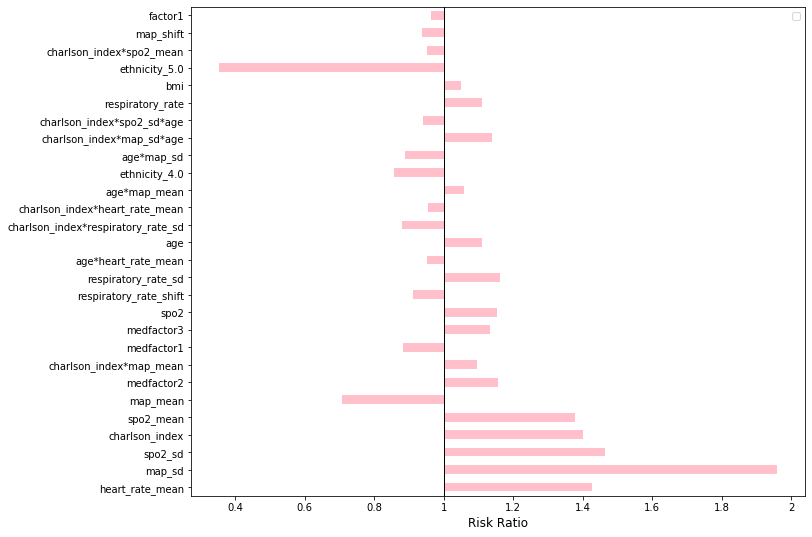

In [392]:
best_features = cph_oneline.summary[["exp(coef)","p"]][cph_oneline.summary['p']<0.05].sort_values(by = "p", ascending=True)

# Change the risk ratios that are less than 0 to be negative
display(best_features)
display(best_features.iloc[0:10,:])

best_features_top10 = best_features.iloc[0:10,:]
best_features_top10 = best_features_top10.sort_values(by = "p", ascending=False)
best_features_top10_series = best_features_top10["exp(coef)"].apply(lambda x: x - 1)

f,ax = plt.subplots(1,1, figsize=(11,9))
best_features["exp(coef)"].apply(lambda x: x - 1).plot(kind='barh', ax=ax, color="pink")
# labels = [
#           "Average heart rate in the last 6h",
#           "Blood Pressure Variability",
#     "SPO variability",
#           "Charlson Comorbidity Index (CCI) score",
#           "Average SPO in the last 6h", 
#           "Average Blood pressure in the last 6h",
#           "Smoking/Alcohol use", 
#           "CCI score x Blood Pressure Average in last 6h", 
#           "History of Hypertension", 
#           "History of heart disease (plus respiratory, urinary, anaemia)"]
# labels.reverse()
# ax.set_yticklabels(labels, fontsize=12)
ax.set_xlabel("Risk Ratio", fontsize=12)
ax.set_xticklabels([0.2,0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2])
ax.axvline(0, color='black', linewidth=1)
ax.legend("")

### Try the Weibull

In [311]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
aft.fit(cox_train_oneline, duration_col="event_time_hrs", event_col="sepsis")
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 26645 observations, 24053 censored>
         event col = 'sepsis'
number of subjects = 26645
  number of events = 2592
    log-likelihood = -18113.06
  time fit was run = 2019-06-29 03:46:44 UTC

---
                                            coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
lambda_ respiratory_rate                   -0.21      0.81      0.08  -2.58   0.01      6.65       -0.36       -0.05
        map                                -0.05      0.96      0.09  -0.49   0.63      0.67       -0.23        0.14
        spo2                               -0.30      0.74      0.07  -4.30 <0.005     15.82       -0.44       -0.16
        heart_rate_shift                    0.03      1.03      0.04   0.58   0.56      0.83       -0.06        0.11
        respiratory_rate_shift              0.18      1.20      0.05   3.57 <0.005     11.47        0.08        0.28
        map_shift                           0.11      1.1

### EXPORT ALL DATASETS - TRAIN AND TEST 
* We will drop the map_coefs, and map_coefs2
* We will keep BOTH spo2_coefs and spo2_coefs_squared

In [317]:
cox_train_oneline.to_csv("train.csv")
cox_test_oneline.to_csv("test.csv")

### EXTRA: GET SURVIVAL FUNCTIONS FOR EVERY PATIENT
* We can use the model to predict the survival curve of every patient over time. I.e., we can predict people's probability of being *free from sepsis* over time. More details are provided in the subsequent notebook **"SEPSIS - Insight (Sci-Kit Survival).ipynb"**, where I provide code to obtain these predictions and plot these for select patients

In [398]:
X = pd.concat([cox_train_oneline.drop(["sepsis","event_time_hrs"], axis=1),cox_test_oneline.drop(["sepsis","event_time_hrs"], axis=1)])
survival_function = cph_oneline.predict_survival_function(X)

In [402]:
all_ids = list(X.index)

In [438]:
# Save a list of all the predictors from Cox regression, so we can predict survival functions
cols = list(cph_oneline.summary.index)

# Join train and test datasets together
X = pd.concat([cox_train_oneline, cox_test_oneline])

# Get the list of all IDs
all_ids = list(X.index)

# Create a data frame called X which is the training data with the predictors in the model
X = X[cols]

# Predict survival functions for every patient in the training data, using the features
survival_function = cph_oneline.predict_survival_function(X, times = np.arange(0,480, step=0.5))

# Assign the column names as the patient ids (this object "cox_train_patient_ids" was saved earlier)
survival_function.columns = all_ids

# Transpose the survival functions
survival_function_t = survival_function.T.reset_index()

survival_function_t = survival_function_t.fillna(1)
survival_function_t = survival_function_t.set_index("index")

# Append the significant columns
# significant columns 
sigcols = list(cph_oneline.summary.loc[cph_oneline.summary.p < 0.05,:].index)

# subsetted data frame 
X_subsetted = X.loc[:,sigcols]

full_survival_functions = pd.concat([X_subsetted,survival_function_t.iloc[:,1:]], axis=1)

full_survival_functions = full_survival_functions.reset_index().rename(columns={"index":"patient_id"})

full_survival_functions.head()

# Get the original scale of the age, bmi, and charlson index values
full_survival_functions[['age','bmi','charlson_index']] = demographics_scaler.inverse_transform(full_survival_functions[['age','bmi','charlson_index']])
full_survival_functions[['heart_rate_mean','respiratory_rate_shift','map_mean','spo2_mean']] = vitals_scale_train.inverse_transform(full_survival_functions[['heart_rate_mean','respiratory_rate_shift','map_mean','spo2']])

# fill nas with 1
full_survival_functions = full_survival_functions.fillna(1)
full_survival_functions['gender'] = full_survival_functions['gender'].replace({0:'Male',1:'Female'})

# Extract only a portion of the IDs (due to the size of the dataset)
subset_train_ids = np.random.choice(cox_train_patient_ids, int(0.2*len(cox_train_patient_ids)), replace=False)
full_survival_functions = full_survival_functions.loc[full_survival_functions['patient_id'].isin(subset_train_ids),:]

# Plot the incidence curve instead of survival curve
full_survival_functions.iloc[:,25:] = np.round(((1 - full_survival_functions.iloc[:,25:])*100),2)

# Export the survival functions
full_survival_functions.to_csv("final_survival_functions_latest.csv")


In [437]:
sigcols

['gender',
 'respiratory_rate',
 'spo2',
 'respiratory_rate_shift',
 'map_shift',
 'heart_rate_mean',
 'map_mean',
 'spo2_mean',
 'respiratory_rate_sd',
 'map_sd',
 'spo2_sd',
 'gender',
 'factor1',
 'medfactor1',
 'medfactor2',
 'medfactor3',
 'ethnicity_4.0',
 'ethnicity_5.0',
 'age',
 'bmi',
 'charlson_index',
 'charlson_index*map_mean',
 'charlson_index*heart_rate_mean',
 'charlson_index*spo2_mean',
 'charlson_index*respiratory_rate_sd',
 'age*map_mean',
 'age*heart_rate_mean',
 'age*map_sd',
 'charlson_index*spo2_sd*age',
 'charlson_index*map_sd*age']